# Select wildfire burn area predictors, fit a regression, & make predictons 

**Show how predictions vary depending between** 
- 1) Regressions fit when temperature is a condidate predictor
- 2) Regression fit when temperature is not a candidate predictor
- 3) Regressio fit when ONLY temperature is a cnadidate predictor. 

- This will be done using the Lasso (L1 Norm), which will be implemented using sk-learn sklearn.linear_model.Lasso()
- A sort of 'relaxed lasso' will be implemented with my custom class relaxo.
- The Lasso() has a single hyperparameter, $\alpha$, which I will selected using leave-one-out cross validation via sklearn.model_selection.LeaveOneOut, the best model will be chosen using sklearn.model_selection.GridSearchCV()

- All predictor features and burn area time series are detrended prior to regression, which helps aviod a [spurious](https://www.svds.com/avoiding-common-mistakes-with-time-series/) relationship between the two. 

In [1]:
%matplotlib inline
import numpy as np
from netCDF4 import Dataset
import os
import matplotlib.pyplot as plt
import time
import pandas as pd
import model_dictionary as md # Modules I have written 
from sklearn import preprocessing # For scaling data 
import met_spread_utils as utils # Script full of methods required for this analysis. 
from shapely.geometry import Polygon, Point
import geopandas
import pickle
from scipy import signal, stats
from matplotlib.patches import Patch # For making custom legends 
from matplotlib.lines import Line2D
import seaborn as sns

In [2]:
transformation = "log10"
cutoff_percentile = 50 # keep the top half of predictors that show up the most
experiment = "CARTHAGE_MUST_BURN_" + str(cutoff_percentile) +"_transofromation_"+ transformation # sigma_scaled_1p0 "no_logs" sigma_scaled
print(experiment)

CARTHAGE_MUST_BURN_50_transofromation_log10


### List the environmental variables to be used to explain historical variance in fire 
- This work used to have 'plant_centric' and 'atmospheric_centric' predictors. 

In [3]:
# The months of burn area to be analyzed (predicted) using the predictors listed above
# and converted to seasonal means. 
burn_area_season = [6, 7, 8]

In [4]:
# Set important paths
CMIP5_dir = os.path.join("..", "Data", "CMIP5", "r1i1p1_rcp_COMMON_GRID")
era_dir   = os.path.join("..", "Data", "ERA-INTERIM", "merged_t_COMMON_GRID")
fire_file = os.path.join("..", "Data","Fire", "MTBS", "bailys_division_acres_burned.csv")

Create or set a directory relevent to these experimental settings. The Directory will be a self contained location that holds all results associated with this script
- Data generated (correlations) as well structures arrays
- Figures associated with regressions and analysis
- This will make a self contained area so that I know what code made what data and what figures go with those.

In [5]:
save_dir_base = os.path.join("..", "Data", "Fire_Analysis", experiment)

if not os.path.isdir(save_dir_base) : 
    os.mkdir(save_dir_base)

In [6]:
# all variables for prediction era names. These variables will be used for lasso_all
predictors = ["t2m", "tp", "si10", "RH", "mrlsl.integrated", "e"]
# these will be the run that has all variables BUT temperature. -- CMIP5 names --
plant_vars = ['pr', 'sfcWind', 'hurs', 'mrlsl.integrated', 'evspsbl'] 
# This will be the temperature only run. OLS? No sure how relaxo will treat 
# this one. -- CMIP5 names --
atmos_vars = ['tas']      

category_dictionary = {"all" : (plant_vars + atmos_vars), 
                       "plant_vars" : plant_vars,
                       "atmos_vars" : atmos_vars
                      }

with open(os.path.join(save_dir_base,"category_dictionary.obj"), 'wb') as fp :
    pickle.dump(category_dictionary, fp)

### Load the Baileys divisions used to subset ecoregions in this analysis 
- Note: Marine Regime Mountains division goes along the coast of Alaska, but the burn area has been exluded there, so exlude in plotting here and later in meteorology. 
- NOTE: If you get annoying "b -no missing" error below, reinstall pyproj

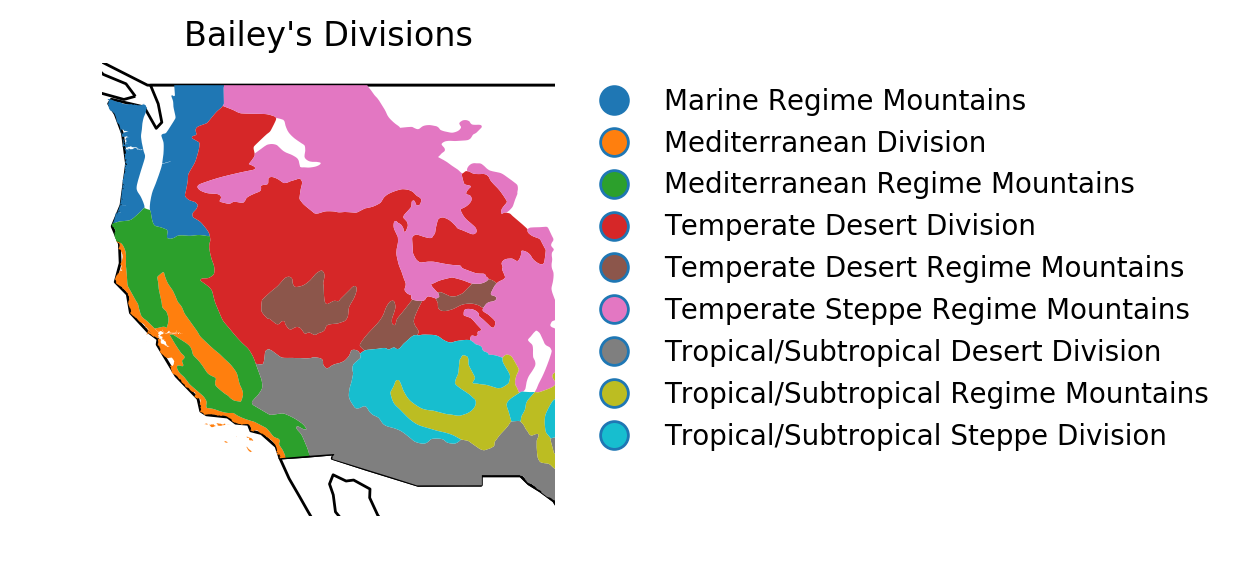

In [7]:
# Load US ecoregions and plot the united states land mass together
eco_dir = os.path.join("..", "Data", "LandCover", "eco-us-shp")
eco_shp = geopandas.read_file(eco_dir)
eco_shp = eco_shp.to_crs({'init': '+init=epsg:4326'})

# For political borders (plotting)
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world.to_crs({'init': '+init=epsg:4326'})

# Western US divisions to be included in this analysis 
desired_divisions = ["Temperate Steppe Regime Mountains", 
                     "Marine Regime Mountains", 
                     #'Marine Division', # No burn area! So will exclude
                     "Mediterranean Regime Mountains", # includes southern coastal Alaska sections
                     "Mediterranean Division",
                     'Temperate Desert Division',
                     "Tropical/Subtropical Steppe Division",
                     'Tropical/Subtropical Desert Division',
                     'Tropical/Subtropical Regime Mountains',
                     'Temperate Desert Regime Mountains',
                    ]

# Make a mask of the desired divisions
division_mask = eco_shp.DIVISION.isin(desired_divisions)
eco_shp_subset = eco_shp.loc[np.array(division_mask),:].copy()

# Join by common division, first subset to AREA and division only, make copy
section_rows = eco_shp_subset[['DIVISION', 'AREA', 'geometry']].copy()
geo_divisions = section_rows.dissolve(by='DIVISION', aggfunc='sum')

# Make row names a column (attribute)
geo_divisions['division'] = geo_divisions.index

# Show the selected divisions 
f, ax = plt.subplots(1, figsize=(3, 3), dpi=200)
base = world.plot(ax=ax, color="white", edgecolor="black")
ax1 = geo_divisions.plot(ax=base, column='division', legend=True)
ax.set_xlim(left=-125, right=-105)
ax.set_ylim(bottom=30, top=50)
ax.axis('off')
plt.title("Bailey's Divisions")

# handle the legend
leg = ax1.get_legend()
leg.set_bbox_to_anchor((1, 1, 1.5, 0.0))
leg.set_frame_on(False)
plt.show()

### Get the desired burn area data for the chosen divisions

In [8]:
# Read in burn area, in acres
fire_df = pd.read_csv(fire_file)

# subset by the desired divisions
division_mask = fire_df.columns.isin(desired_divisions)
print("--------------------------------")
print("Divisions used in this analysis:")
print("--------------------------------")

fire_df_subset = fire_df.loc[:,np.array(division_mask)].copy()

# MTBS data start Jan 1984, are monthly, and end in 2017. Make
# a time array date_range that matches this. 
time_mtbs = pd.date_range("1984-01-01", periods=len(fire_df), freq="M")

# Make the monthly time series the row index for the division fire data 
fire_df_subset.index = time_mtbs.copy()

fire_df = fire_df_subset.copy()
divisions = np.array(fire_df.columns)
del(fire_df_subset)
print(divisions)

--------------------------------
Divisions used in this analysis:
--------------------------------
['Marine Regime Mountains' 'Temperate Desert Division'
 'Temperate Steppe Regime Mountains'
 'Tropical/Subtropical Desert Division'
 'Tropical/Subtropical Steppe Division'
 'Tropical/Subtropical Regime Mountains' 'Mediterranean Regime Mountains'
 'Mediterranean Division' 'Temperate Desert Regime Mountains']


### Show a timeseries of division burn area

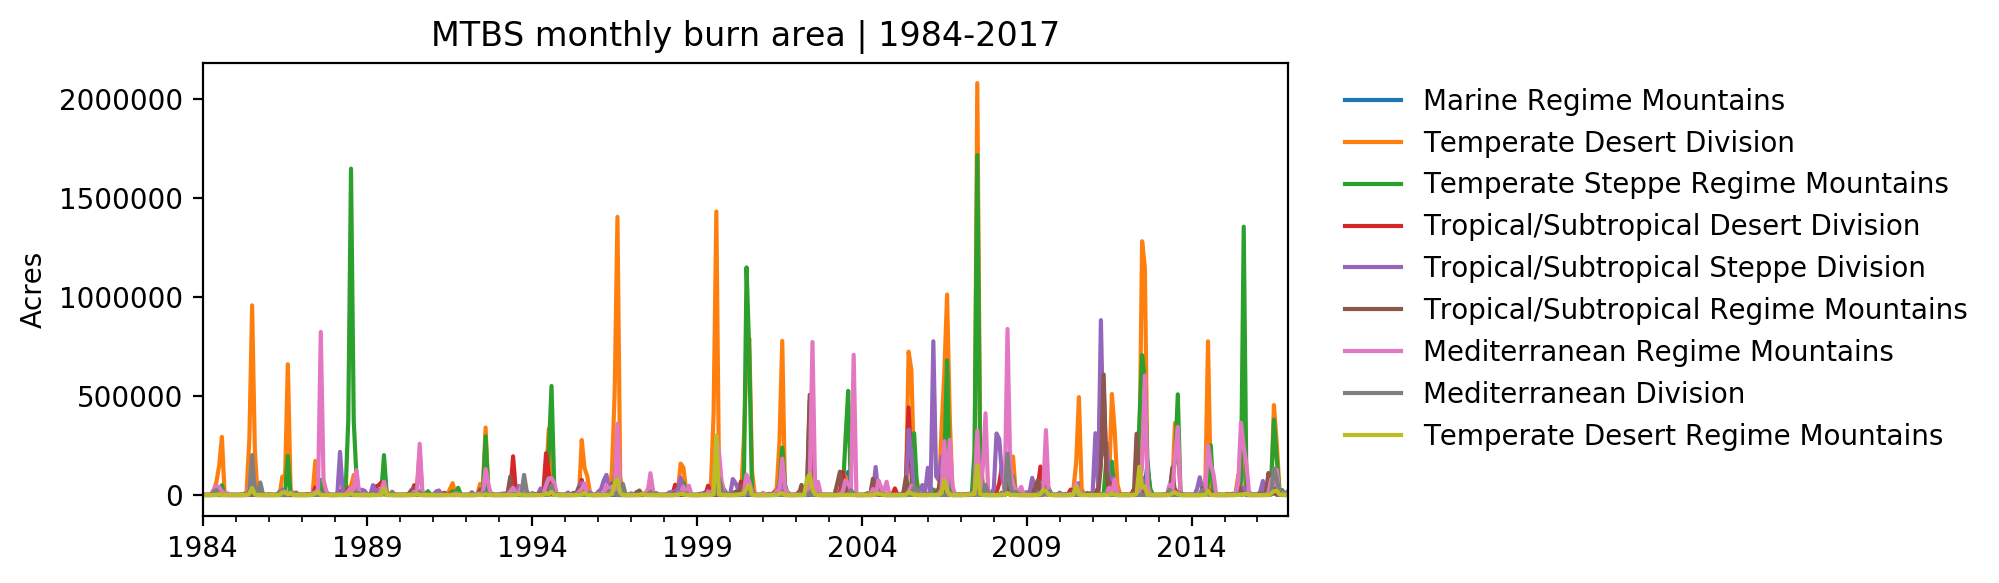

In [9]:
# Show the disolved divisions 
f, ax = plt.subplots(1, figsize=(7, 3), dpi=200)
#plt.plot(time_mtbs, BA)
ax1 = fire_df.plot(ax=ax)
plt.title("MTBS monthly burn area | 1984-2017")
plt.ylabel("Acres")

# handle the legend
leg = ax1.get_legend()
leg.set_bbox_to_anchor((0.15, 1, 1.5, 0.0))
leg.set_frame_on(False)

plt.show()

### Bring in the western_US region to bring along for analysis
- This will allow large scale patterns to be observed
- Provide sanity checks on units
- Allow large area sigma in variables to be computed.
- Calculate burn area in region as sum of each ecoregion burn areas for each month. 

In [10]:
divisions = np.append(divisions, "western_US")
divisions

array(['Marine Regime Mountains', 'Temperate Desert Division',
       'Temperate Steppe Regime Mountains',
       'Tropical/Subtropical Desert Division',
       'Tropical/Subtropical Steppe Division',
       'Tropical/Subtropical Regime Mountains',
       'Mediterranean Regime Mountains', 'Mediterranean Division',
       'Temperate Desert Regime Mountains', 'western_US'], dtype=object)

In [11]:
western_US_burn_area = fire_df.sum(axis=1).copy()
fire_df["western_US"] = western_US_burn_area

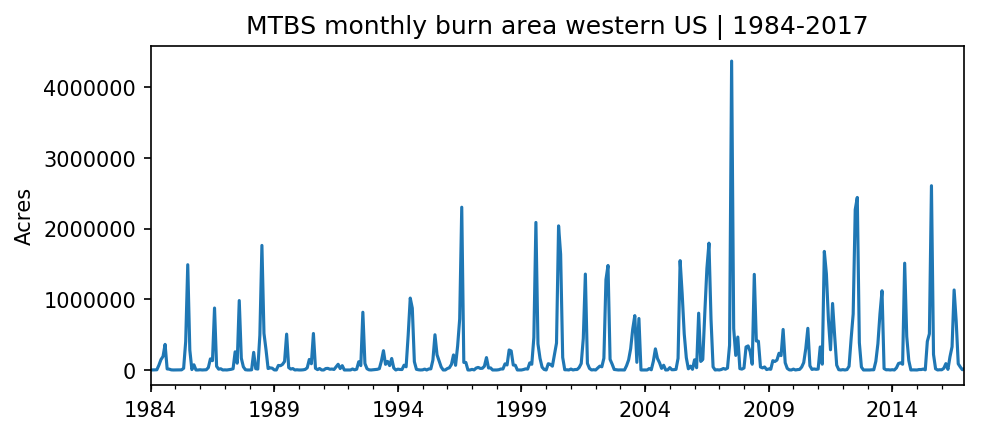

In [12]:
f, ax = plt.subplots(1, figsize=(7, 3), dpi=150)
ax1 = western_US_burn_area.plot(ax=ax)
plt.title("MTBS monthly burn area western US | 1984-2017")
plt.ylabel("Acres")
plt.show()

# Get Bailey's region corrosponding meteorology grids
- We make the assumption that the burn area in the baily's regions mapped above is driven my meteorology over the same spatial region. ERA-interim met (for training) and CMIP5 (for future projections) have been gridded to a common grid and I have figured out what grid boxes overlap what Bailey's divisions. 
- The following code gets masks for each bailey's division within the desired_divisions array. This allows us to subset the gridded meteorology for only the grid boxes that overlap the spatial area of interest. The spatial overlaps and mask creation was done with Python/create_ecoregion_overlap_masks.ipynb

In [13]:
# I need to know what met grid cells to keep with these divisions. Find which ones overlap. 
grid_division_masks_file = os.path.join("..", "Data", "LandCover", "bailys_division_masks_common_grid.nc")
nc = Dataset(grid_division_masks_file, 'r')

grid_lat = nc.variables['lat'][:].data
grid_lon = nc.variables['lon'][:].data

# Leave the file open

Function for getting era_nc_vals. Will be moved out of notebook when development is complete

In [14]:
def get_era_nc_variable(var, spatial_mask, spatialMean=False, startYear=1983):
    """
    # TODO: Move to utils
    This function will be for loading a particular nc file, which will be spatially subset.
    The data loaded are from the merged_t_COMMON_GRID directory. These data have been
    regridded from thier native resolution using cdo remapbil. 
    
    TODO: Add "endyear" as an argument in addition to "startyear" as new MTBS fire data is 
    TODO: going to require going further back in time to train the model. 
    
    Parameters
    ----------
        var : str, The variable (and file name) of the ECMWF era-interim data to be 
              loaded. 
        spatial_mask : numpy array, where equal to 0 are locations to keep data for and 
                       where equal to 1 (True) are grid points to mask (ignore data). 
        spatialMean : Boolean, if False (default) a spatial mean of the era-interim data
                      is not taken and the data are returned on a t,lon,lat grid. 
                  
    Return
    ------
        valsCut : The chosen "var" as a ndarray(t, lat, lon) or if spatialMean = True
                  ndarray(t). 
        t_monCut : pd.date_range describing the t axis of valsCut. 
        lonCut : longitude ndarray
        latCut : latitude ndarray
    
    """
    
    # Create link to the monthly file
    dataDir = os.path.join("..", "Data", "ERA-INTERIM", "merged_t_COMMON_GRID")
    f = var + "_1983-2017.nc" 
    loadFile = os.path.join(dataDir, f)
    
    # Check to see if the file exists! 
    if(not os.path.isfile(loadFile)):
        raise ValueError(f + " File does not exist")
    
    # Load the nc data
    nc = Dataset(loadFile)
    vals = nc.variables[var][:]
    lon = nc.variables["lon"][:]
    lat = nc.variables["lat"][:]
    
    # Create a new array, where each time slice will be a masked version 
    # of the data loaded from the nc file 
    vals_masked = np.ma.empty(shape=vals.shape)
    
    # Pandas handling of time so all models have the exact same origin and such. 
    t = nc.variables["time"]
    if(len(t) == 420):
        # Convert to pandas time array, on the assumption t[0]=startYear-01-01 the data
        # being monthly. Defualt files are 1983-2017.  
        t_mon = pd.date_range(str(startYear)+"-01-01", periods=len(t), freq="M")
    else:
        # there should always be 420 months in these data (35 years of data times 12)
        raise ValueError('Error in number of months for file: '+ f + " 420 expected.")
        
    # Now subset the data based on the passed spatial_mask
    for i in range(len(t)) : 
        vals_masked[i,:,:] = np.ma.masked_array(vals[i,:,:], mask=spatial_mask, copy=True)
    
    # take a spatial mean? 
    if spatialMean:
        # Masked entries are ignored
        vals_masked = np.ma.mean(vals_masked, axis=(1,2))
    
    return vals_masked, t_mon, lon, lat

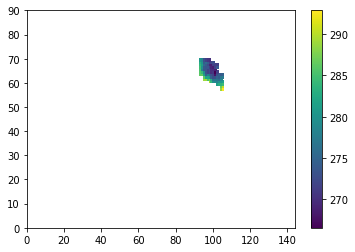

In [15]:
# Demonstrate that the masked array masks data outside of area of interst
t2m, t, lon, lat = get_era_nc_variable('t2m', nc.variables["western_US"][:]==0)
plt.pcolor(t2m[0,:,:])
plt.colorbar()
plt.show()

### Load desired ERA-Interim reanalysis
- Load each variable, take the spatial mean for the spatial_masks shown above and place in a dataframe where each row is a month and each column is a variable, each cell is a monthly mean value for the area. 

In [16]:
def get_division_era_variables(predictors, spatial_mask) : 
    """
    This script employs get_era_nc_variable() and loads the desired predictors 
    for a given ecoregion (division). The spatial mask needs to be passed. The
    spatial me of the data for a given division is taken when using this method
    because it returns a dataframe where the columns are the predictors and the 
    rows are the spatially average monthly-mean values. 
    
    Parameters
    ----------
        predictors : list, the era-interim variables to load. 
        spatial_mask : numpy.ndarray containing True and False values only. Values
                       are true for grid boxes not desired (to be used as masked) 
                       and values are False for the area with data to be averaged
                       spatially. 
    
    return
    ------
        A pd.DataFrame where the columns are the predictors and the 
        rows are the spatially average monthly-mean values. 
        
    """

    predictorDict = {}

    for var in predictors :

        predictorDict[var], t, lon, lat = get_era_nc_variable(var, spatial_mask, spatialMean=True)

    # Features used to estimate the target function    
    X_monthly = pd.DataFrame(predictorDict, index=t)
    
    return X_monthly 

In [17]:
predictors

['t2m', 'tp', 'si10', 'RH', 'mrlsl.integrated', 'e']

In [18]:
divisions

array(['Marine Regime Mountains', 'Temperate Desert Division',
       'Temperate Steppe Regime Mountains',
       'Tropical/Subtropical Desert Division',
       'Tropical/Subtropical Steppe Division',
       'Tropical/Subtropical Regime Mountains',
       'Mediterranean Regime Mountains', 'Mediterranean Division',
       'Temperate Desert Regime Mountains', 'western_US'], dtype=object)

In [19]:
nc.variables.keys()

odict_keys(['lon', 'lon_bnds', 'lat', 'lat_bnds', 'Hot Continental Division', 'Hot Continental Regime Mountains', 'Marine Division', 'Marine Regime Mountains', 'Mediterranean Division', 'Mediterranean Regime Mountains', 'Prairie Division', 'Rainforest Regime Mountains', 'Savanna Division', 'Savanna Regime Mountains', 'Subarctic Division', 'Subarctic Regime Mountains', 'Subtropical Division', 'Subtropical Regime Mountains', 'Temperate Desert Division', 'Temperate Desert Regime Mountains', 'Temperate Steppe Division', 'Temperate Steppe Regime Mountains', 'Tropical Subtropical Desert Division', 'Tropical Subtropical Regime Mountains', 'Tropical Subtropical Steppe Division', 'Tundra Division', 'Tundra Regime Mountains', 'Warm Continental Division', 'Warm Continental Regime Mountains', 'western_US'])

Marine Regime Mountains
[False  True]


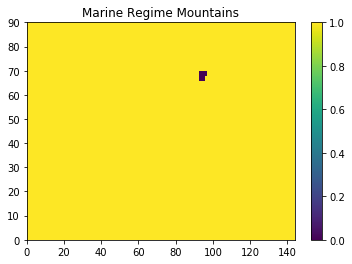

Temperate Desert Division
[False  True]


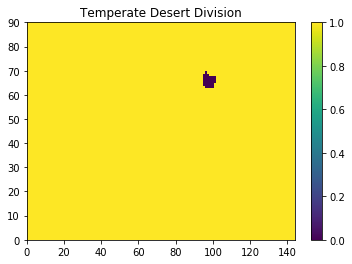

Temperate Steppe Regime Mountains
[False  True]


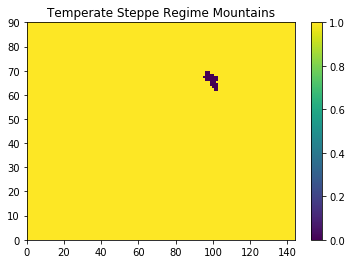

Tropical Subtropical Desert Division
[False  True]


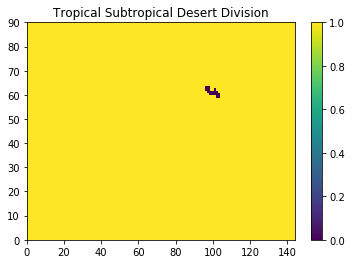

Tropical Subtropical Steppe Division
[False  True]


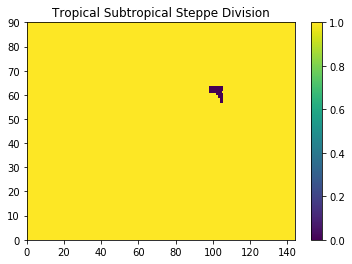

Tropical Subtropical Regime Mountains
[False  True]


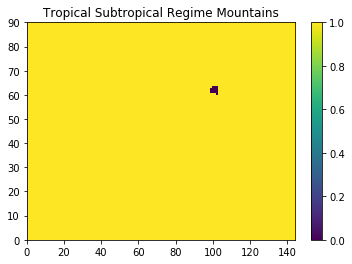

Mediterranean Regime Mountains
[False  True]


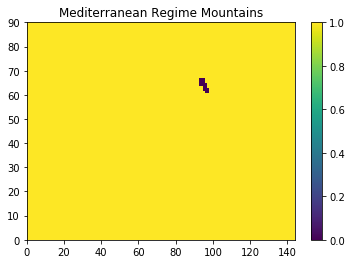

Mediterranean Division
[False  True]


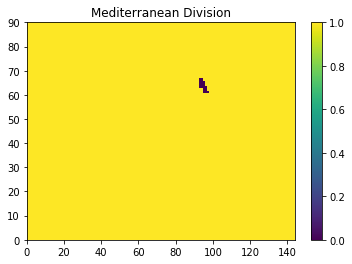

Temperate Desert Regime Mountains
[False  True]


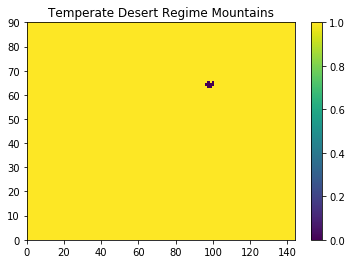

western_US
[False  True]


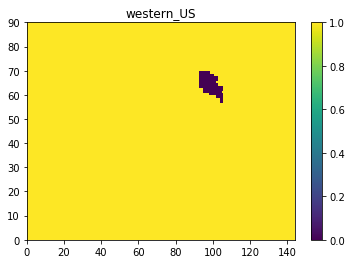

In [20]:
# Dictionary to store monthly values for predictors (era data)
X_monthly_dict = {}

for div in divisions : 
    
    # Remove forbiden charactors 
    division_key = div.replace("/", " ")
    #print(division_key)
    # NOTE: The division masks are stored such that 1 means in division, 0 means not.
    # NOTE: np.ma masking requires a true or 1 for values to mask, i.e. ignore, so 
    # NOTE: the data from the nc file for divisions is flipped when getting division 
    # NOTE: data 
    print(division_key)
    div_mask = nc.variables[division_key][:].data == 0
    
    print(np.unique(div_mask))
    
    plt.figure()
    plt.pcolor(np.array(div_mask, dtype=int) )
    plt.colorbar()
    plt.title(str(division_key) )
    plt.show()
    
    X_monthly_dict[div] = get_division_era_variables(predictors, div_mask)
    #print(np.sum(X_monthly_dict[div].tp))
    
nc.close()

### Change units of some ERA-Interim data to match CMIP5 output
Extensive notes can be found on these conversions in the file Python/make_era_and_CMIP5_units_identical.ipynb


#### Convert units on fields that need it 

In [21]:
print(predictors)

['t2m', 'tp', 'si10', 'RH', 'mrlsl.integrated', 'e']


In [22]:
for div in divisions : 
    
    # Get a regions met values to change units for 
    X_monthly = X_monthly_dict[div]
    
    tp = utils.m_to_mass_flux( np.array(X_monthly["tp"].copy()) )
    e = utils.e_to_mass_flux( np.array(X_monthly["e"].copy()) ) 
    
    # Replace columns with updated versions
    X_monthly.loc[:, "tp"] = tp
    X_monthly.loc[:, "e"] = e 
    
    # Finally, make the names of the era-interim variables match the names
    # in CMIP5 output. After this step, the units and names should match. 
    # t2m tp si10 RH slhf VPD mrso e
    X_monthly.rename(columns={"t2m":"tas","tp":"pr","si10":"sfcWind","RH":"hurs", 
                              "mrlsl.integrated":"mrlsl.integrated", "e":"evspsbl"}, 
                     inplace=True)
    
    # Place back in dictionary 
    X_monthly_dict[div] = X_monthly
    #print(X_monthly.columns)

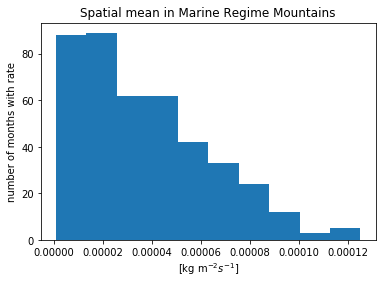

In [23]:
plt.figure()
plt.hist(X_monthly_dict['Marine Regime Mountains'].pr)
plt.xlabel("[kg m$^{-2}s^{-1}$]")
plt.title("Spatial mean in Marine Regime Mountains")
plt.ylabel("number of months with rate")
plt.show()

In [24]:
divisions

array(['Marine Regime Mountains', 'Temperate Desert Division',
       'Temperate Steppe Regime Mountains',
       'Tropical/Subtropical Desert Division',
       'Tropical/Subtropical Steppe Division',
       'Tropical/Subtropical Regime Mountains',
       'Mediterranean Regime Mountains', 'Mediterranean Division',
       'Temperate Desert Regime Mountains', 'western_US'], dtype=object)

### Setup forecasting summer burn area using seasonal (varying t-lag) predictors and calculating summer burn area

#### Seasons to aggregate features
- summer (6,7,8)
- spring (3,4,5)
- winter (11,12,1,2) 

TODO: 
- Other previous years seasons? 

In [25]:
def make_monthly_seasonal(X_monthly, time_mtbs, inspect=False) :
    """
    Makes monthly met predictors seasonal by taking monthly predictors (features) 
    to means of seasons, winter=[11,12,1,2], spring=[3,4,5], summer=[6,7,8]. For 
    winter predictor, the months 11 and 12 will come from the previous year, so 
    when making predictors for a row (year) 2013, the months to be averaged are
    Nov 2012, Dec 2012, Jan 2013, Jan 2014. This is all meant to forecast burn area
    occurring in the months 6,7,8 (summer). 
    NOTE: When using this to convert CMIP5 monthly predictors to seasonal, because 
    NOTE: the time_mtbs argument will be cmip time, the first years (1984) _winter
    NOTE: features will be an average of Jan 1984 and Feb 1984, since there is no 
    NOTE: data for the previous year. All other year winter predictors are normal.
    
    Parameters
    ----------
        X_monthly : pd.DataFrame object with shape [months x features] where the index
                    is a datetimes.DatetimeIndex
        time_mtbs : datetimes.DatetimeIndex that matches either monthly burn area series
                    (for era-interim data) or the X_montly.index (for cmip data).
        inspect : When True, the masked time array used for each years seasonal predictors
                  will be printed. 
                  
    return
    ------
        pd.DataFrame : A dataframe [year x seasonal_feature] where each feature in the 
                       X_monthly pd.DataFrame has been expanded to var_winter, var_spring
                       var_summer. 
    """
        
    # Create summer burn area time series
    fire_years  = np.sort(np.unique(time_mtbs.year))
    nYears      = len(fire_years)

    # ERA data starts one year before the burn area data 
    era_time = X_monthly.index.copy()
    era_year = era_time.year
    era_month = pd.Series(era_time.month)

    # Create season masks (first month last month of season). Each season gets its own 
    # column in the features DataFrame.
    # NOTE: Make sure to not use months after wildfires in a given year, e.g. 
    # NOTE: December, unless set to the year before # Make sure to not use months 
    # NOTE: after wildfires in a given year, e.g. December, unless set to the year before 
    seasons = {"winter":[11,12,1,2], 
               "spring":[3,4,5], 
               "summer":[6,7,8]}

    # Make a dictionary to store predictors for each variable for each season 
    # of interest. 
    variables = np.array( X_monthly.columns.copy() )
    
    # To store predictor information 
    predictor_dict = {} 

    for pre in variables :
        for s in seasons.keys() :
            predictor_name = pre + "_" + s 
            predictor_dict[predictor_name] = np.zeros(nYears)

    # Loop through each year, assigning desired season predictor value 
    # within each year 
    for i in range(nYears):
        
        if inspect :
            print(fire_years[i])
        
        # Loop through seasons, within a year
        for s in seasons.keys():
            
            if inspect : 
                print(s)

            if s == 'winter' : 
                
                prev_year_mask = (fire_years[i]-1) == era_year
                m1 = era_month.isin([11,12])
                tChuchk1 = prev_year_mask & m1
                
                this_year_mask = fire_years[i] == era_year
                m2 = era_month.isin([1,2])
                tChuchk2 = this_year_mask & m2
                # Want an array than combines the True locations, "or" in other
                # words 
                tChunk = tChuchk1 | tChuchk2
                
                if inspect :
                    print(era_time[tChunk])
                
            else :
                
                # The non-winter predicors months fall into the same year as fire activity
                year_mask = fire_years[i] == era_year
                
                # Mask the months that fall into the current season of interest
                month_mask = era_month.isin(seasons[s])

                # combine to make a single mask
                tChunk = month_mask & year_mask 
                
                if inspect :
                    print(era_time[tChunk])

            # For each predictor variable, loop through taking relevant stat
            for pre in variables:
                k = pre + "_" + s
                predictor_dict[k][i] = np.mean(X_monthly.loc[era_time[tChunk], pre].copy())
    
    # Return a DataFrame of era data as desired seasonal features 
    return pd.DataFrame(predictor_dict, index=fire_years)

### Make monthly era data into seasonal means for each division 

In [26]:
X_seasonal_dict = {}
for div in divisions : 
    X_seasonal_dict[div] = make_monthly_seasonal(X_monthly=X_monthly_dict[div], time_mtbs=time_mtbs)
    
# these data need to be saved
with open(os.path.join(save_dir_base, "ERA_features_dict.obj"), 'wb') as fp :
    pickle.dump(X_seasonal_dict, fp)

### Make monthly burn area data into target season burn area totals 
https://stackoverflow.com/questions/38792122/how-to-group-and-count-rows-by-month-and-year-using-pandas

In [27]:
# Subset rows to burn_area_season, then 
df_= fire_df[fire_df.index.month.isin(burn_area_season)].copy()
# Aggregated by season is the target function, y, so start calling it y. 
y_seanonal_df = df_.groupby(df_.index.year).agg('sum').copy()
del(df_)

In [28]:
y_seanonal_df.head()

,Marine Regime Mountains,Temperate Desert Division,Temperate Steppe Regime Mountains,Tropical/Subtropical Desert Division,Tropical/Subtropical Steppe Division,Tropical/Subtropical Regime Mountains,Mediterranean Regime Mountains,Mediterranean Division,Temperate Desert Regime Mountains,western_US
1984,0,505875,49397,8244,1335,1260,104754,25565,4101,700531
1985,24869,1463166,156596,9653,0,17047,230031,229035,42785,2173182
1986,11087,841269,201099,18261,35000,0,26435,2541,28642,1164334
1987,11903,241368,88488,54298,21241,30747,860073,2049,23874,1334041
1988,17386,185048,2396621,33062,37883,2468,77565,9240,10140,2769413


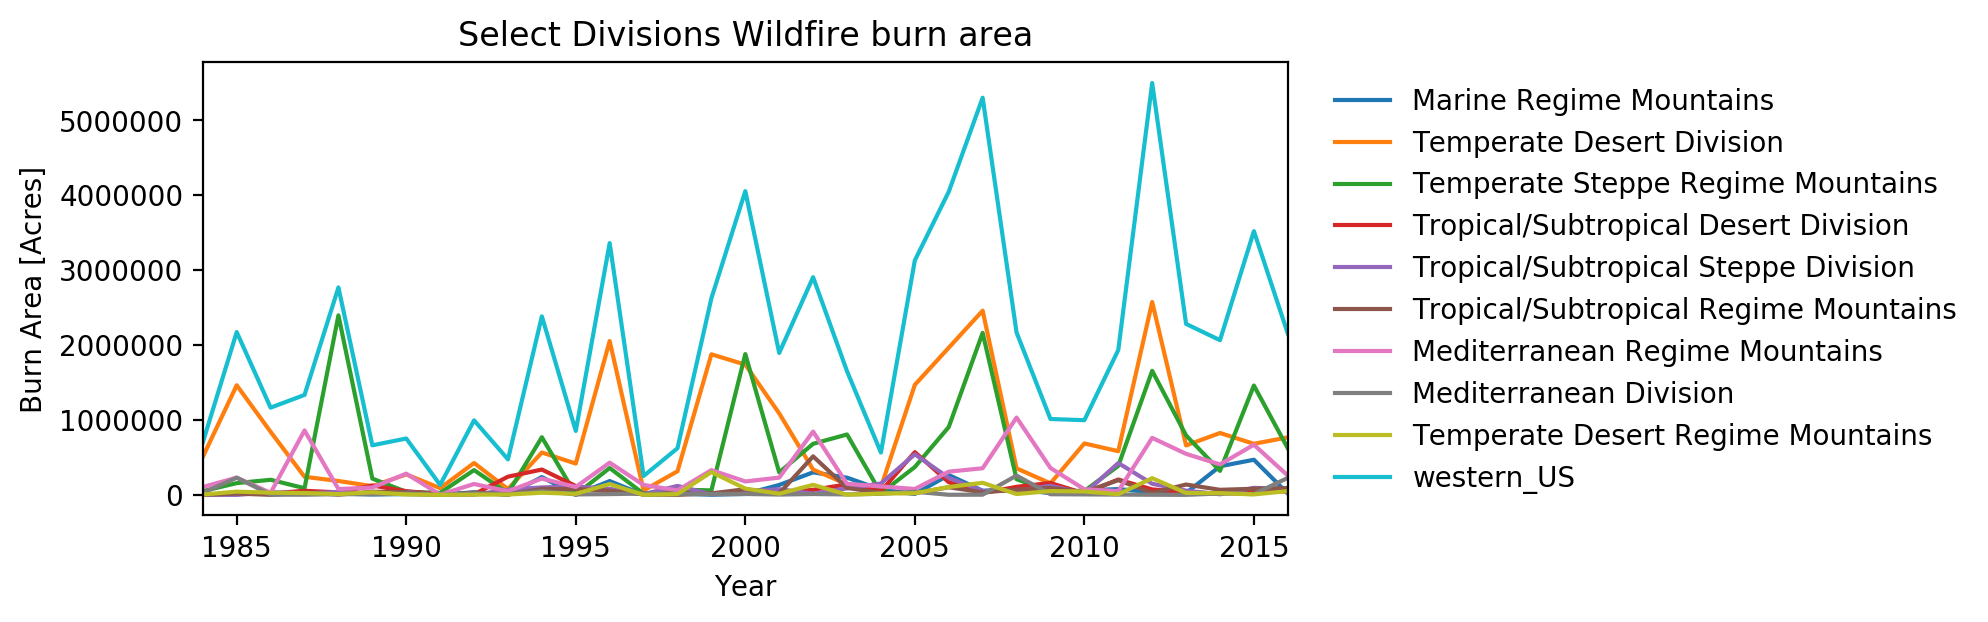

In [29]:
f, ax = plt.subplots(1, figsize=(7, 3), dpi=200)
y_seanonal_df.plot(ax=ax)
plt.title("Select Divisions Wildfire burn area")
plt.ylabel("Burn Area [Acres]")
plt.xlabel("Year")
plt.legend()

# handle the legend
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.14, 1, 1.5, 0.0))
leg.set_frame_on(False)

plt.show()

## Standardize and detrend the predictors (features) for seasonal burn area variance analysis
- The mean and standard deviation of the features needs to be saved in order for bias correcting CMIP5 output later. 
- These data need to be detrended before regression. 
- Sets up forecasting year to year variability without interference on long term trends, a different analysis
- **NOTE:** Pandas.DataFrame.std() uses ddof=1 by default, while numpy uses ddof=0 by defualt. Make sure you are consistent otherwise the way data standard deviation is expressed will change throughout use. 

# TODO: This may need to be sanity checked again. 
- Make sure variables align, values are sensible, etc. I am now worried that changes observed, in terms of sigma, are too high and dont make sense

In [30]:
# Dictionary to store DataFrames of the standardized features
Z_dict = {}

feature_names = X_seasonal_dict[list(X_seasonal_dict.keys())[0]].columns

# Argument, detrend the data? Consequences down the pipeline as far as it goes. 
detrend = True

# Make DataFrames where the means and std of feature data can be saved 
# [division x feature]
X_mean_df = pd.DataFrame(np.nan, index = X_seasonal_dict.keys(),
                         columns = feature_names)
# [division x feature]
X_std_df = pd.DataFrame(np.nan, index = X_seasonal_dict.keys(),
                        columns = feature_names)
# [division x feature]
era_feature_slope = pd.DataFrame(np.nan, index = X_seasonal_dict.keys(),
                                 columns = feature_names)
era_feature_slope_pvalue = pd.DataFrame(np.nan, index = X_seasonal_dict.keys(),
                                        columns = feature_names)

for i in divisions : 
    
    # Get the features for a division
    X = X_seasonal_dict[i]
    x = X.index.values # for getting linear regression, units with years
    
    # Calculate and store in correct location, means and std
    # NOTE: detrending does not change the mean 
    X_mean_df.loc[i, X.mean().index] = X.mean().copy()
    
    if detrend :
        
        for feature in X.columns : 
            
            # Regression on the feature
            xi = X.loc[:, feature].values 
            lm = stats.linregress(x, xi)
            era_feature_slope.loc[i, feature] = lm.slope
            era_feature_slope_pvalue.loc[i, feature] = lm.pvalue
        
        # Create a temporary df to save desired features of
        # pd DataFrame, while they are converted to an array
        # for detrending using scipy.signal 
        df_temp = pd.DataFrame(np.nan, columns=X.columns.values, index=X.index.values)
             
        # Make a de-trended version of these data
        X_detrended     = signal.detrend(X.values, axis=0)
        X_detrended_std = np.std(X_detrended, axis=0)
        
        # Standardize the X feature data and store in Z_dict
        X_std_df.loc[i, X.columns.values] = X_detrended_std
        
        Z_detrended = ( X_detrended / X_detrended_std )
        #print(Z_detrended.std(axis=0))
        
        df_temp.iloc[:,:] = Z_detrended
        Z_dict[i] = df_temp
                
    else :
        
        # Standardize the X feature data and store in Z_dict
        X_std_df.loc[i, X.std().index] = X.std(ddof=0).copy()
        Z_dict[i] = ( (X-X.mean()) / X.std(ddof=0) ).copy()
    
# Save these mean and std values, they are needed for projections
X_mean_df.to_csv(os.path.join(save_dir_base, "feature_means.csv"))
X_std_df.to_csv(os.path.join(save_dir_base, "feature_std.csv"))

# Save the slopes and their pvalues, this could be handy later
era_feature_slope.to_csv(os.path.join(save_dir_base, "feature_slopes.csv"))
era_feature_slope_pvalue.to_csv(os.path.join(save_dir_base, "feature_slopes_pvalues.csv"))

In [31]:
Z_dict['Marine Regime Mountains'].columns

Index(['tas_winter', 'tas_spring', 'tas_summer', 'pr_winter', 'pr_spring',
       'pr_summer', 'sfcWind_winter', 'sfcWind_spring', 'sfcWind_summer',
       'hurs_winter', 'hurs_spring', 'hurs_summer', 'mrlsl.integrated_winter',
       'mrlsl.integrated_spring', 'mrlsl.integrated_summer', 'evspsbl_winter',
       'evspsbl_spring', 'evspsbl_summer'],
      dtype='object')

In [32]:
X.loc[:, feature].dtype

dtype('float64')

### Implement a custom cross validation scheme that minimizes leave one out sample error
- Alpha varies how harsh the model is, the bigger alpha, the more predictors are eliminated. When alpha = 0 Lasso is the same as OLS regression. And with this many features, it will FOR SURE be overfit. 
- Below the slope of wildfire burn area, as well as slope alpha, are saved.
- The Lasso is fit to 1) all variables available at once, 2) atmos-centric variables only, 3) plant-centric variables only. The results for all three are saved, including the trained regressions themselves. 
- TODO: Evaluate and come up with some metric for stability. 


````Python 
for year_left_out in range(1984:2016) :
    Xs = X[!year_left_out, ]
    
    leave_one_out_model = LassoCV()

 Calculate mean error for this alpha
````

In [33]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LassoCV, Lasso, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import warnings # For all kinds of converge issues

In [34]:
def plot_all_relationships(Y, X, ecoregion) : 
    """
    Scatterplot the burn area data against all features. One axis per
    feature, and each feature season is a different color.
    
    Parameters
    ----------
        Y : The variable we are trying to predict
        X : The matrix (dataframe) of features used to predict Y. Show
            scatter relationship. 
            
    """
    eco_write = ecoregion.replace(" ","_").replace("/"," ")
    scatter_fig = os.path.join(save_dir_base, eco_write + "_Z_vs_burn_area.png")
    
    n_features = X.shape[1]
    feature_names = X.columns
    
    fig = plt.figure(figsize=(10,15), dpi=200)
    
    panel = 0
    for feature in feature_names :
        panel += 1
        ax = plt.subplot(8, 3, panel)    
        x = X.loc[:, feature ]
        r = np.round(np.corrcoef(x, Y)[0][1], 4)
        
        plt.scatter(x, Y.values, label="r=%f" % r)
        plt.title(feature)
        plt.legend()
        plt.xlabel("")
        plt.gca().axes.get_yaxis().set_visible(False)
    
    fig.suptitle(ecoregion +" burn area vs feature", fontsize=14)
    plt.subplots_adjust(hspace=0.4)
    plt.savefig(fname=scatter_fig, format='png')
    plt.close()
    

def show_model_skill(y_orig, z, y, model, var_type, fname, div, transformation="log10") :
    """
    Predict historical values using optimal alphas.
    plots the following:
        1) model coeficients
        2) y vs. y_hat time series
        3) y vs. y_hat 1:1
        4) model residuals
        
        # TODO: Make into a class. 
        
    Parameters
    ----------
        y : the target values as an array
        Z : the features used to predict the target as a pd.DataFrame
        model : from LassoCV or similar, to be sumarized
        fname : image save location
    
    """
    
    years = np.array(z.index)
    
    # Make prediction
    y_hat = model.predict(z)
    
    # Setup figure 
    fig = plt.figure(dpi=200, figsize=(22, 12))
    
    fig.suptitle(div + " " + var_type  + " regression summary", fontsize=14)
    
    #########################################################
    # Show the target function that we are trying to predict 
    #########################################################
    plt.subplot(2, 4, 1)
    plt.plot(years, y_orig, "-o", label="MTBS")
    plt.axhline(y=0, linestyle="--", color="k")
    plt.legend()
    plt.title("Unaltered MTBS burn area")
    
    ##########################################
    # Plot distribution before log10 transformation
    ##########################################
    if transformation == 'log10' : 
        transformed = 10**y
        xlabel = "10^(detrended( log_{10}(y ))"
    else :
        transformed = y
        xlabel = "detrended y"
        
    plt.subplot(2, 4, 2)
    plt.hist( y )
    plt.xlabel(xlabel)
    plt.ylabel("count")
    plt.title("Distribution of the detrended target")
    
    ########################################
    # Plot distribution 
    ########################################
    plt.subplot(2, 4, 3)
    plt.hist( y )
    if transformation == 'log10' : 
        plt.xlabel("detrended( log10(y) )")
    else :
        plt.xlabel("detrended y ")
        
    plt.ylabel("count")
    plt.title("Distribution of the detrended target")
    
    ##########################################
    # Show the coeficients for the model_best
    ##########################################
    plt.subplot(2, 4, 4)

    plt.bar(z.columns.values, model.coef_)
    plt.axhline(y=0, c="k", linestyle="--")
    plt.xticks(rotation='vertical')
    plt.xlabel("Feature")
    plt.ylabel("Coefficients")
    plt.title("Feature coefs for least square error model, $\\alpha$=" + str(np.round(model.alpha_, 4)))
    #plt.xticks(rotation=45)

    ########################################
    # Plot obs and modeled values for both
    ########################################
    r2 = np.round(metrics.r2_score(y_true=y, y_pred=y_hat),4)
    plt.subplot(2, 4, 5)
    plt.plot(years, y, '-o', label="transformed observation")
    plt.plot(years, y_hat, '--o', label="model")
    plt.ylabel("log$_{10}$(acres burned)")
    plt.legend()
    plt.title("Time series & mode | R$^{2}$=" + str(r2))

    ########################################
    # Show the MSE path across alphas 
    ########################################
    plt.subplot(2, 4, 6)
    plt.plot(model.alphas_, np.mean(model.mse_path_, axis=1), label="mean MSE across folds")
    plt.xlabel(r"$\alpha$")
    plt.ylabel("Mean MSE of folds")
    plt.axvline(model.alpha_, color="k", linestyle="--", label="selected $\alpha$")
    plt.title("RMS path across " + r"$\alpha$")
    
    ########################################
    # Plot observations vs. modeled values
    ########################################
    x1 = np.linspace( np.min([y, y_hat]), np.max([y, y_hat]) )
    r = np.round(np.corrcoef(y, y_hat)[0][1], 3)

    plt.subplot(2, 4, 7)
    plt.plot(x1, x1, color="k", linestyle=":", label="1:1")
    plt.scatter(y, y_hat, c=years)
    plt.xlabel("Observation")
    plt.ylabel("Predicted")
    plt.title("Observation vs. predicted values | r="+str(r))
    plt.colorbar()

    ########################################
    # Plot residuals 
    ########################################
    zero = np.zeros(len(years))
    
    plt.subplot(2, 4, 8)
    plt.scatter(years, y-y_hat)#, c=years)
    plt.plot(years, zero, color="k", linestyle=":")
    if transformation == 'log10' : 
        plt.ylabel("log$_{10}$(acres burned)")
    else :
        plt.ylabel("acres burned")
        
    plt.title("Model residuals")
    
    # overall styling
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    plt.savefig(fname=fname, format='png')
    plt.close()
    
def separate_predictors(atmos_vars, plant_vars, x) : 
    """
    Separates predictor DataFame (x) into plant and atmos centric predictos 
    based on the lists atmos_vars and plant_vars. 
    """
    # Clean up the symbols for precise str.contains statements 
    atmos_vars_str = str(atmos_vars).replace("'","").replace(" ","").replace(",","|").replace("[","").replace("]","|").replace("pr","pr_")[:-1]
    plant_vars_str = str(plant_vars).replace("'","").replace(" ","").replace(",","|").replace("[","").replace("]","|").replace("pr","pr_")[:-1]
    # make masks
    atmos_mask = np.array(pd.Series(x.columns).str.contains(atmos_vars_str))
    plant_mask = np.array(pd.Series(x.columns).str.contains(plant_vars_str))
    
    x_atmos = x.iloc[:, atmos_mask].copy()
    x_plant = x.iloc[:, plant_mask].copy()

    return x_atmos, x_plant


def get_OLS_score(Z, y) : 
    """
    Gets r-squared score for a target using a matrix of features. 
    """
    linear_model = LinearRegression()
    _ = linear_model.fit(Z, y)
    score = linear_model.score(Z, y)
    return score

### Setup the DataFrames that will save the key results
- to save for plotting and analysis purposes elsewhere. 

In [35]:
# Create a dataframe for a summary of results from multiple linear
# models 
results_df = geo_divisions.copy()

# Blank array for setting column values to nothing before valueas
# assigned
blank= np.full(results_df.shape[0], np.nan)

results_df['OLS_r2']        = blank.copy() # variance explained by OLS - no regularization

results_df['lasso_r2']      = blank.copy() # variances explained by lasso regression, all variables
results_df['lasso_alpha']   = blank.copy() # alpha selected by cross validation

results_df['atmos_r2']      = blank.copy() # variance explained by atmos only R-squared
results_df['atmos_alpha']   = blank.copy() # Optimal alpha value for atmos

results_df['plant_r2']      = blank.copy() # variance explained by plant only R-squared 
results_df['plant_alpha']   = blank.copy() # Optimal alpha value for plants 


# Create a place to store coeficients in a dataframe [division x feature]
predictors = X_seasonal_dict[list(X_seasonal_dict.keys())[0]].columns.values
lasso_all_coefs   = pd.DataFrame(0, index=divisions, columns=predictors)

# Make plant- and atmos-centric specific coef storage containers 
plant_col_mask = []
atmos_col_mask = []
for p in predictors : 
    # Only plant predictors go into this one
    if pd.Series(p.split("_")[0]).isin(plant_vars)[0] :
        plant_col_mask.append(True)
    else :
        plant_col_mask.append(False)
        
    # And only atmos ones here
    if pd.Series(p.split("_")[0]).isin(atmos_vars)[0] :
        atmos_col_mask.append(True)
    else:
        atmos_col_mask.append(False)
        
plant_col_mask = np.array(plant_col_mask)
atmos_col_mask = np.array(atmos_col_mask)

lasso_atmos_coefs = pd.DataFrame(0, index=divisions, columns=predictors[atmos_col_mask])
lasso_plant_coefs = pd.DataFrame(0, index=divisions, columns=predictors[plant_col_mask])

# Create a dataframe to save information about the trends in burn area
df_slopes = pd.DataFrame(np.nan, index=divisions, columns=["slope", "pvalue"])

## Lasso Regression Fitting
- TODO: create outside loop for external cross validation. 
    - For what is done now, repeated for EVERY year left out. Keep track of
        - Selected alpha
        - square error on left out year
        - the non-zero coeficients. This will give a confidense on how often a given variable is selected, if there is massive changes from year to year, that should be reported and we can better understand how stable/unstable the solutions are. 
        

print(divisions)
print(len(divisions))

#### testing area for relaxo
# TODO: Save this in its own file and import it 

In [36]:
class relaxo() :
    """
    Custom implementation of the double lasso. The idea is to use lasso twice. 
    First time through use it explicitly for variable selection (what features
    have coef values not equal to zero) and then again for linear regression
    fitting regularization. The second use only uses features that had non-zero
    coefs on X% of external loop leave one out iterations. 
    
    TODO: Return R-squared on the test set for the alpha value with the lowest 
    TODO: mean-square-error 

    """
    
    def __init__(self, X, y) : 
        """
        Parameters
        ----------
            y : pd.Series, these are the data to predict.  
            X : These are the features used to predict y. The goal
                of this class is to eliminate the not so useful features
                in X, to make better predictions on y. 
                transformation : transformation of y. 
        """
        self.X = X
        self.y = y        
        self.feature_names = X.columns.values 
    
    def subset_features(self, max_iter = 100000, tol = 0.001, normalize=False, inspect=False) : 
        """
        First layer of lasso regression to be used for variable selection. We keep 
        track of what features are selected to have non-zero coefs where the 
        lassoCV is fit to each year left out of the data, a bit like external 
        cross validation. 

        Parameters
        ----------
            max_iter, tol, normalize : see LassoCV() 

        """
        
        y = np.array(self.y) # needs to be np.array for maths
        X = self.X           # will be made a np.array later

        if type(X) is pd.DataFrame : 

            example_labels = X.index.values
            n_examples = X.shape[0]
            n_features = X.shape[1]
            feature_names = X.columns
            
        # Handle the type of the data 
        #if type(X) is np.ndarray :
        #    n_examples = X.shape[0]
        #    n_features = X.shape[1]
        #    example_labels = np.linspace(1, n_examples, n_examples)
        #    feature_names  = np.linspace(1, n_features, n_features)

        else :

            raise TypeError("X type: '" + str( type(X) ) + "' is not accepted. pd.Dataframe expected at this time. ")
            
        # X needs to be a np.array for the rest of this method
        X = np.array(X)
            
        if inspect :
            print(n_examples)
            print(example_labels)
            print(feature_names)
            print(n_features)
        
        # save the LassoCV alpha value for each year left out
        outer_alphas = [] 

        # Keeps track of each time a coef had a non-zero coef
        coef_counter = pd.DataFrame(0, index=[1], columns=feature_names)
        
        # for a given year left out of outside loop, what was the coef,
        # consisency will be interesting. 
        coef_values = pd.DataFrame(0, index=example_labels, columns=feature_names)
        
        # Outer loop, exclude every example once. The example iterator is what is
        # left out. 
        warnings.filterwarnings('ignore')
        count = 0
        for example in example_labels : 
            
            if inspect :
                print("leaving out: " + str(example))
                print(examples_to_keep)
            
            examples_to_keep = example_labels != example
            X_year_out       = X[examples_to_keep, :]
            y_year_out       = y[examples_to_keep]
            
            # Fit the data using leave one out 
            m = LassoCV(cv=LeaveOneOut(), normalize=normalize, tol=tol, max_iter=max_iter)
            m.fit(X_year_out, y_year_out)
            
            # TODO: Make predictions on year left out? 

            # Store fit information
            outer_alphas.append(m.alpha_)
            coef_values.loc[example, :] = m.coef_
            coef_counter.loc[1, (np.abs(m.coef_) > 0) ] += 1
            
            # progress bar
            if inspect : 
                count += 1
                print("percent completed: %f" %(100.*count/len(example_labels)))
            
        # Turn warnings back on
        warnings.filterwarnings('default')
        
        # Store these dataframes
        self.coef_counter = coef_counter
        self.coef_values  = coef_values
        self.outer_alphas = outer_alphas

        return coef_values, coef_counter, outer_alphas 

    def second_lasso(self, cutoff_percentile=0, max_iter = 100000, tol = 0.001, normalize=False) : 
        """
        Implements LassoCV() with leave-one-out to 
        find the final model. This uses the subset 
        of X values that were determined to be useful
        with the external nest
            Parameters
            ----------
                cutoff_percentile : Percentile to which to cuttoff a feature. If a feature
                                    was not selected in more than cutoff_percentile of the 
                                    external loops of subset_features() then do not include
                                    it for fitting here. When exactly zero, no feature selection
                                    is performed and all of X variables are used. 
                max_iter : see LassoCV()
                tol : see LassoCV()
                normalize: see LassoCV(), set to false because our data are centered
                           by design. 
                           
            return 
            ------
                lasso_model : The Lasso model fit using the columns of X specified as True
                              by the original_features_kept_mask. 
                X : pd.DataFrame, the dataframe used for the second fit. 
                original_features_kept_mask : Logical, the features (columbns) used (where True) 
                                     for this lasso.  
        """
        
        y = self.y
        if cutoff_percentile == 0 :
            # DO NOT subset X at all. 
            X = self.X
            print("X is not being subset")
            self.cutoff = 0
            original_features_kept_mask = np.array([True]*X.shape[1])
            
        else :
            # Subset using the specified percentile
            X_all = self.X 
             
            cutoff = np.percentile(self.coef_counter.loc[1, :].values, cutoff_percentile)
            self.cutoff = cutoff 
            original_features_kept_mask = np.array(self.coef_counter.loc[1, :].values >= cutoff)
            X = X_all.loc[:, original_features_kept_mask].copy()
            
        self.X_second_lasso = X
            
        # Store the cutoff percentile 
        self.cutoff_percentile = cutoff_percentile
        
        lasso_model = LassoCV(cv=LeaveOneOut(), normalize=normalize, tol=tol, max_iter=max_iter)
        lasso_model.fit(X.values, y)
        
        # Make this model available externally
        self.lasso_model = lasso_model 
        self.original_features_kept_mask = original_features_kept_mask
        
        # TODO: translate these coefs back to original data locaitons (columns)
        return lasso_model, X, original_features_kept_mask
    
    def plot_subset_stats(self, include_second = False, cutoff_percentile=50) :
        """
        Visualizes the results of the feature selection performed by subset_features.
        
        Parameters
        ----------
            include_second : Logical, whether to plot the results of the second lasso or not. 
            cutoff_percentile : The percentile by which features are excluded from the 
                                second use of lasso. The figures in this method visualize
                                where the percentile falls along the metadata associated 
                                with the external loop. Overidden when inclide_seconf is True. 
            
        """
        
        counts = self.coef_counter.loc[1, :].values
        
        if include_second : 
            cutoff  = self.cutoff
            cutoff_percentile = self.cutoff_percentile
        else :
            cutoff = np.percentile(counts, cutoff_percentile)
        
        n_loops = self.coef_values.shape[0]
        
        fig = plt.figure(dpi=300, figsize=(15,10))
        
        # Feature occurrence hist ----------
        ax1 = plt.subplot(231)
        h=plt.hist(counts)
        ax1.axvline(cutoff, c="r", label="cutoff for second lasso to see")
        plt.xlabel("Number of times a feature was used")
        plt.ylabel("Count for frequency")
        plt.legend()
 
        # Feature occurrence barplot ----------
        bar_colors = np.array(["C0"]*self.coef_counter.shape[1])
        if include_second :
            # Translate lasso_model non-zero coef features back
            # to full dimension of features that were used. 
            m1 = self.original_features_kept_mask 
            m2 = np.where(m1)[0][self.lasso_model.coef_!=0]
            bar_colors[m2] = "r"
        
        ax2=plt.subplot(232)
        self.coef_counter.loc[1, :].plot.bar(ax=ax2, color=bar_colors)
        ax2.axhline(cutoff, c="r")
        plt.title("feature selected out out of %i" %n_loops)
        
        # feature mean coef vs. feature occurrence scatter ----------
        ax3=plt.subplot(233)
        mean_coef_value  = np.abs(self.coef_values.mean() )
        used_count = self.coef_counter.loc[1, :] 
        plt.scatter( mean_coef_value, used_count, c = bar_colors)
        plt.xlabel("mean coef outside loop")
        plt.ylabel("count used outside loop")
        plt.title("feature mean coef vs times used")
        plt.axhline(cutoff, c="r")
        
        legend_elements = [Line2D([0], [0], marker='o', color='w', 
                                  label='original feature', markerfacecolor='C0', markersize=15),
                           Line2D([0], [0], marker='o', color='w', 
                                  label='selected by second lasso', markerfacecolor='r', markersize=15)
                          ]
        
        ax3.legend(handles=legend_elements, loc='best')
        
        # alpha distribution ----------
        ax4=plt.subplot(234)
        h2=plt.hist(self.outer_alphas)
        if include_second :
            plt.axvline(self.lasso_model.alpha_ , c="purple", label="second lasso selected alpha")
            plt.legend()
        plt.xlabel("LassoCV(leaveOneout).alpha_")
        plt.ylabel("occurrence over external loop")
        
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        
        # heat map of the coeficients from external loop ----------
        ax5 = plt.subplot(235)
        with sns.plotting_context("poster") :
            
            sns.heatmap(self.coef_values, center=0, cmap="bwr", ax=ax5)
            ax5.set(xlabel="", ylabel="year left out", title="Regression Coeficients")

### RELAXO IMPLEMENTATION 

````Python 
X # [years x features]
y # yearly burn area
for year_left_out in 1983 to 2016 : 
    
    X_subset = X with year_left_out 
    
    # leave-one-out cross validation over an array of alpha values
    model = lassoCV(X_subset, y, cv=LeaveOneOut)  
    
# sort features from selected the fewest to most times by
# the loop above. Keep the features that were selected more
# that the middle value of this array. Call this X_good_features

# leave-one-out cross validation over an array of alpha values
final_model = lassoCV(X_good_features, y, cv=LeaveOneOut)  

# Done! 

````

In [37]:
# Parameters # defaults 
max_iter = 100000 # 1000
tol      = 0.001 #0.0001

# When zero, the results of this section should not change but that needs to be confirmed. 
print("cutoff_percentile used: %f" % cutoff_percentile)
# The type of transformation to take on the burn area data 
print("Taking transformation: " + transformation)

# Create storage dictionaries 
div_lasso_list = {}    # A dictionary to store the trained regressions associated with divisions 
div_relax_list = {}    # A dictionary to store the trained relaxo. More information that just the lasso_model. 
div_lasso_targets = {} # save what was fitted
div_ylog10 = {}        # Save the log10 values before detrending 
div_BA_original = {}   # Save the orignal burn area values

years = y_seanonal_df.index.values

#divGo = [divisions[7]]

for div in divisions : #divGo : # 
    
    div_lasso_list[div] = {}
    div_relax_list[div] = {}
    
    print("Training " + div)
    ##########################################################################
    # Handle transformations of the target (burn area)
    ##########################################################################
    y_original = y_seanonal_df.loc[:, div].copy()
    
    if transformation == "log10" :
        # We replace 0 values with 1 so that taking the base 10 logarithm is valid
        y_original.loc[y_original==0] = 1.
        y_log = np.log10(y_original.values)
        y_log_detrend = signal.detrend(y_log)
        y = y_log_detrend.copy()
        
        div_ylog10[div] = y_log
        
    elif transformation == "none" : 
        # Do not alter the burn area, aside from taking the
        # autoregression (slope) away.
        y_detrend = signal.detrend(y_original)
        y = y_detrend.copy()
        
    else :
        raise ValueError("tansformation not reconize. Choose valid transformation.")
        
    # Get the detrended normalized features for prediction
    Z = Z_dict[div]    
        
    # Plot the relationship between the burn area in this region and 
    # all standardized features. 
    plot_all_relationships(Y=y_original, X=Z, ecoregion=div)
    
    # Save important components of the transformations above
    div_lasso_targets[div] = y
    div_BA_original[div] = y_original
        
    # Save the stats on the burn area trends
    linear_model = stats.linregress(years, y_original.values)
    df_slopes.loc[div, "slope"] = linear_model.slope
    df_slopes.loc[div, "pvalue"] = linear_model.pvalue
        
    # Save OLS score
    results_df.loc[div, 'OLS_r2'] = get_OLS_score(Z.values, y) 
    
    #################################################################################
    # Fit a Lasso model using LOO 
    # - We set normalize= False since our predictors are already normalized
    #lasso_model = LassoCV(cv=LeaveOneOut(), normalize=False, tol=tol, max_iter=max_iter)
    #lasso_model.fit(Z.values, y)
    print("    Working on lasso_all")
    relax_all = relaxo(X=Z, y=y)
    _, _, _ = relax_all.subset_features(inspect=False)
    lasso_model, Z_subset, _ = relax_all.second_lasso(cutoff_percentile=cutoff_percentile)
    
    # Save desired output 
    results_df.loc[div, 'lasso_alpha']= lasso_model.alpha_
    results_df.loc[div, 'lasso_r2'] = lasso_model.score(Z_subset, y)
    lasso_all_coefs.loc[div, Z_subset.columns] = lasso_model.coef_
        
    # Save a plot of these results. 
    fname = os.path.join(save_dir_base, div.replace("/"," ").replace(" ","_") + "_all.png")
    show_model_skill(y_original, Z_subset, y, lasso_model, "all vars", fname, div, transformation)
    # Show nested results summary 
    fname = os.path.join(save_dir_base, div.replace("/"," ").replace(" ","_") + "_all_nest_summary.png")
    relax_all.plot_subset_stats(include_second=True)
    plt.savefig(fname)
    plt.close()
    
    # Save the trained classifier
    # TODO: the names of the columns need to be saved!!!!
    div_lasso_list[div]["lasso_all"] = lasso_model
    div_relax_list[div]["lasso_all"] = relax_all
    
    # Repeat, but now only use either atmos or plant centric predicts, one at a time
    # save results. 
    Z_atmos, Z_plant = separate_predictors(atmos_vars, plant_vars, Z)
    
    #################################################################################
    # Fit a Lasso model using atmos only
    #lasso_atmos = LassoCV(cv=LeaveOneOut(), normalize=False, tol=tol, max_iter=max_iter)
    #lasso_atmos.fit(Z_atmos, y)    
    print("    Working on lasso_atmos")
    relax_atmos = relaxo(X=Z_atmos, y=y)
    _, _, _ = relax_atmos.subset_features(inspect=False)
    lasso_atmos, Z_atmos_subset, _ = relax_atmos.second_lasso(cutoff_percentile=cutoff_percentile)
    
    results_df.loc[div, 'atmos_r2'] = lasso_atmos.score(Z_atmos_subset.values, y) 
    results_df.loc[div, 'atmos_alpha'] = lasso_atmos.alpha_
    lasso_atmos_coefs.loc[div, Z_atmos_subset.columns] = lasso_atmos.coef_
    
    # Save a plot that shows summary of results
    fname = os.path.join(save_dir_base, div.replace("/"," ").replace(" ","_") + "_atmos.png")
    show_model_skill(y_original, Z_atmos_subset, y, lasso_atmos, "atmos-centric", fname, div, transformation)
    
    fname = os.path.join(save_dir_base, div.replace("/"," ").replace(" ","_") + "_atmos_nest_summary.png")
    relax_atmos.plot_subset_stats(include_second=True)
    plt.savefig(fname)
    plt.close()
    
    div_lasso_list[div]["lasso_atmos"] = lasso_atmos
    div_relax_list[div]["lasso_atmos"] = relax_atmos
    
    #################################################################################
    # Fit a Lasso model using plant only 
    #lasso_plant = LassoCV(cv=LeaveOneOut(), normalize=False, tol=tol, max_iter=max_iter)
    #lasso_plant.fit(Z_plant.values, y)    
    print("    Working on lasso_plant")
    relax_plant = relaxo(X=Z_plant, y=y)
    _, _, _ = relax_plant.subset_features(inspect=False)
    lasso_plant, Z_plant_subset, _ = relax_plant.second_lasso(cutoff_percentile=cutoff_percentile)
    
    results_df.loc[div, 'plant_r2'] = lasso_plant.score(Z_plant_subset, y)     
    results_df.loc[div, 'plant_alpha'] = lasso_plant.alpha_
    lasso_plant_coefs.loc[div, Z_plant_subset.columns] = lasso_plant.coef_

    fname = os.path.join(save_dir_base, div.replace("/"," ").replace(" ","_") + "_plant.png")
    show_model_skill(y_original, Z_plant_subset, y, lasso_plant, "plant-centric", fname, div, transformation)
    
    fname = os.path.join(save_dir_base, div.replace("/"," ").replace(" ","_") + "_plant_nest_summary.png")
    relax_plant.plot_subset_stats(include_second=True)
    plt.savefig(fname)
    plt.close()
    
    div_lasso_list[div]["lasso_plant"] = lasso_plant
    div_relax_list[div]["lasso_plant"] = relax_plant
    
    print("Done training " + div)
        
#warnings.filterwarnings('default')

print("Done training all divisions!")

# Save the trained classifiers 
# TODO: Best practice would be to save the features and target these
# TODO: were trained on. 
with open(os.path.join(save_dir_base, "trained_regressions.obj"), 'wb') as fp :
    pickle.dump(div_lasso_list, fp)
    
with open(os.path.join(save_dir_base, "relaxo_regressions.obj"), 'wb') as fp :
    pickle.dump(div_relax_list, fp)
    
if transformation == 'log10' : 
    with open(os.path.join(save_dir_base, "div_log10_burn_area_dict.obj"), 'wb') as fp :
        pickle.dump(div_ylog10, fp)
    
with open(os.path.join(save_dir_base, "div_original_burn_area_dict.obj"), 'wb') as fp :
    pickle.dump(div_BA_original, fp)

cutoff_percentile used: 50.000000
Taking transformation: log10
Training Marine Regime Mountains
    Working on lasso_all
    Working on lasso_atmos
    Working on lasso_plant
Done training Marine Regime Mountains
Training Temperate Desert Division
    Working on lasso_all
    Working on lasso_atmos
    Working on lasso_plant
Done training Temperate Desert Division
Training Temperate Steppe Regime Mountains
    Working on lasso_all
    Working on lasso_atmos
    Working on lasso_plant
Done training Temperate Steppe Regime Mountains
Training Tropical/Subtropical Desert Division
    Working on lasso_all
    Working on lasso_atmos
    Working on lasso_plant
Done training Tropical/Subtropical Desert Division
Training Tropical/Subtropical Steppe Division
    Working on lasso_all
    Working on lasso_atmos
    Working on lasso_plant


/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Done training Tropical/Subtropical Steppe Division
Training Tropical/Subtropical Regime Mountains
    Working on lasso_all


/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


    Working on lasso_atmos
    Working on lasso_plant
Done training Tropical/Subtropical Regime Mountains
Training Mediterranean Regime Mountains
    Working on lasso_all
    Working on lasso_atmos
    Working on lasso_plant
Done training Mediterranean Regime Mountains
Training Mediterranean Division
    Working on lasso_all
    Working on lasso_atmos


/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


    Working on lasso_plant
Done training Mediterranean Division
Training Temperate Desert Regime Mountains
    Working on lasso_all
    Working on lasso_atmos
    Working on lasso_plant


/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Done training Temperate Desert Regime Mountains
Training western_US
    Working on lasso_all
    Working on lasso_atmos
    Working on lasso_plant
Done training western_US
Done training all divisions!


In [107]:
with open(os.path.join(save_dir_base, "div_log10_burn_area_dict.obj"), 'wb') as fp :
    pickle.dump(div_ylog10, fp)

- There is some .iloc trickery occuring below to account for for the fact that I do not have a geometry for western_US and even if I did it would not make sense to save in the same geodataframe since it would overwrite all the rest in plotting. 

In [38]:
results_df

,geometry,AREA,division,OLS_r2,lasso_r2,lasso_alpha,atmos_r2,atmos_alpha,plant_r2,plant_alpha
DIVISION,,,,,,,,,,
Marine Regime Mountains,(POLYGON ((-123.9529577897323 45.5324935644400...,3.050647e+11,Marine Regime Mountains,0.757939,0.688633,0.021696,8.859963e-02,0.157820,0.734131,0.002850
Mediterranean Division,(POLYGON ((-118.2534183715204 33.7468069108849...,8.918718e+10,Mediterranean Division,0.547470,0.060757,0.381564,0.000000e+00,0.333903,0.262643,0.203629
Mediterranean Regime Mountains,POLYGON ((-118.7468180350099 34.83583837405344...,2.415300e+11,Mediterranean Regime Mountains,0.736131,0.595214,0.016299,1.582758e-01,0.047188,0.566955,0.023103
Temperate Desert Division,(POLYGON ((-110.255691511287 39.58573912874999...,6.957500e+11,Temperate Desert Division,0.700016,0.520223,0.007214,1.560887e-01,0.060534,0.521523,0.005457
Temperate Desert Regime Mountains,(POLYGON ((-116.9203265874518 40.4735944840465...,1.130000e+11,Temperate Desert Regime Mountains,0.470354,0.000000,0.347405,9.814994e-02,0.113759,0.000000,0.315502
Temperate Steppe Regime Mountains,(POLYGON ((-104.2797775681042 44.7604408312882...,5.844300e+11,Temperate Steppe Regime Mountains,0.866786,0.817653,0.009731,6.831315e-01,0.018234,0.773915,0.004996
Tropical/Subtropical Desert Division,POLYGON ((-101.9419173542224 31.21309074628787...,4.495000e+11,Tropical/Subtropical Desert Division,0.735027,0.620398,0.004452,1.879361e-01,0.033706,0.608883,0.001182
Tropical/Subtropical Regime Mountains,(POLYGON ((-105.8721695834743 35.4560089643861...,1.302000e+11,Tropical/Subtropical Regime Mountains,0.467507,0.000000,0.314716,2.220446e-16,0.269305,0.109691,0.118489
Tropical/Subtropical Steppe Division,(POLYGON ((-97.01796727329044 27.9451595718080...,6.597828e+11,Tropical/Subtropical Steppe Division,0.467702,0.000000,0.204576,1.057312e-01,0.001346,0.000000,0.204167


In [39]:
# save the results_df
# NOTE: western_US division appended as bottom row. We do not want to write these.
# NOTE: Hense, the :-1 row call to be written. 
results_df.iloc[:-1,:].to_file(filename=os.path.join(save_dir_base, 'results_geo_df'))
# NOTE: index subsetting for excluding western_US (last row) and geometrcy (first column)
results_df_ = pd.DataFrame(results_df.iloc[:-1,1:].copy())
results_df_.to_csv(os.path.join(save_dir_base, 'results_df.csv'))

/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


In [40]:
# Save the coef DataFrames as well.
lasso_all_coefs.to_csv( os.path.join(save_dir_base, 'lasso_all_coefs.csv') )

# Create and save the plant coefs df
#lasso_plant_coefs = pd.DataFrame(lasso_plant_coefs.iloc[:, 3:]).copy()
lasso_plant_coefs.to_csv( os.path.join(save_dir_base, 'lasso_plant_coefs.csv') )

# Create and save the atmos coefs df 
#lasso_atmos_coefs = pd.DataFrame(lasso_atmos_coefs.iloc[:, 3:]).copy()
lasso_atmos_coefs.to_csv( os.path.join(save_dir_base, 'lasso_atmos_coefs.csv') )

# Create and save a combined coefs from the plant- and atmos-centric regressions
# that were performed independently. 
lasso_combined_coefs = pd.concat([lasso_plant_coefs, lasso_atmos_coefs], axis=1, sort=False)
lasso_combined_coefs.to_csv( os.path.join(save_dir_base, 'lasso_combined_coefs.csv') )

# Save out trends in burn area 
df_slopes.to_csv( os.path.join(save_dir_base, 'burn_area_trends.csv') )

**NOTE:** Different divisions will need different variables, based on where coefs are greater than zero, so
different divisions will have different models and total models with availability. 

# Examine selected variables spread in CMIP5 data from RCP45 and RCP85
#### For a given division (ecoregion)
- What predictors are required based on non-zero coefs? 
- Get those predictors loaded into a DataFrame [month x variable]
    - Make sure this is the same size (same # of columns and column names) as X_monthly. That way coeficients from the lasso can be applied across columns. 
- Make into seasonal predictors, using make_monthly_seasonal(), exactly same method as for era-iterim data
- Repeat last two bullet-points for all available CMIP5 models

In [41]:
def get_cmip5_nc(var, rcp, model, spatial_mask, spatial_mean=False, inspect=False):
    """
    This function will be for loading a particular CMIP5 NetCDF file, which will be spatially subset 
    by this function. These CMIP5 model output to be loaded have been regridded to the "Common grid" 
    using $ cdo remapbil. Defualts to taking the spatial mean of all global data for the var argument. 
    Change area loaded using the minX, maxX, etc. arguments. 
    
    Parameters
    ----------
        var : str, The CMIP5 variable name to be loaded. File names match variable names. 
        rcp : str, "45" or "85", refers to representative concentration pathway. 
        model : The name of the model that created the var, to be loaded from. 
        spatial_mask : numpy array, where equal to 1 (True) are locations to mask, meaning
                       they will NOT be used in calculations, spatial means, etc. 
        spatial_mean : Boolean, if False (default) the data  will be returned on a 
                       [t, lon, lat] grid. 
    
    Return
    ------
        valsCut : array[month, lat, lon] for the chosen spatial extent or 
                  array[month] spatial mean for the chosen spatial extent. 
        t_mon : array of months as pd.date_range object. 
        lon : array of longitude values that were used aftering trimming the global data
        lat : array of latitude values that were used after trimming the global data
    
    """
        
        
    # TODO: Mask out nans also! 
        
    if var == 'mrso' :
        domain = 'Lmon'
    elif var == 'mrlsl.integrated' :
        domain = 'Lmon'
    else :
        domain = 'Amon'
        
    # Create link to the monthly file in this projects directory structure. 
    dataDir = os.path.join(".." ,"Data" ,"CMIP5" ,'r1i1p1_rcp_COMMON_GRID')
    f = var + "_" + domain + "_" + model + "_rcp" + rcp + "_r1i1p1_198301-210012.nc"
    
    if inspect :
        print(f)
        
    loadFile = os.path.join(dataDir, f)
    
    # Check to see if the file exists! Data logs indicate that not all requests exist
    if(not os.path.isfile(loadFile)):
        raise ValueError(f+ " File does not exist")
    
    # Load the nc data
    nc = Dataset(loadFile)
    vals = nc.variables[var][:]
    lon = nc.variables["lon"][:]
    lat = nc.variables["lat"][:]
    
    # Create a new array, where each time slice will be a masked version 
    # of the data loaded from the nc file 
    vals_masked = np.ma.empty(shape=vals.shape)
    
    # Pandas handling of time so all models have the exact same origin and such. 
    # TODO: handle required changes to this section for when historical CMIP5 data
    # TODO: are also used. 
    t = nc.variables["time"]
    if(len(t) == 1416) :
        # Convert to pandas time array, on the assumption t[0]=2006-01 & t[-1]=2100-12
        t_mon = pd.date_range("1983-01-01", periods=len(t), freq="M")
    else:
        raise ValueError('Error in number of months for file: '+ f + " 1416 expected.")
        
    # Now subset the data based on the passed spatial_mask
    for i in range(len(t)) : 
        vals_masked[i,:,:] = np.ma.masked_array(vals[i,:,:], mask=spatial_mask, copy=True)
    
    # Now, take the mean value in this spatial domain. Note, the 
    # same is done to the era-interim data using the method:
    # get_era_nc_vals()
    if spatial_mean :
        
        # There is some extra stuff in here to make sure that
        # values of np.nan for soil moisture also get masked. 
        # i.e., in short, this masked all np.nan values too 
        # when time means of the division masked values are taken. 
        
        spatial_mask_3d = vals_masked.mask
        nan_mask = np.isnan(vals_masked.data)
        combined_mask = spatial_mask | nan_mask
        vals_masked_new = np.ma.array(vals_masked, mask=combined_mask)
        
        spatial_mean_values = np.ma.mean(vals_masked_new, axis=(1,2))
        vals_masked = spatial_mean_values.data # if you do not do this, forces dtype object in dataframe. 
                    
        if False :
            
            print("Spatial Mask types")
            print(type(spatial_mask_3d))
            print(spatial_mask_3d.shape)
            print("nan_mask")
            print(type(nan_mask))
            print(nan_mask.shape)
            print("combined_mask")
            print(type(combined_mask))
            print(combined_mask.shape)
            print("vals_masked_new")
            print(vals_masked_new.shape)
        
    nc.close()
    
    return vals_masked, t_mon, lon, lat

Get an array with all possible models available. 

In [42]:
import glob as glob
DIR = os.path.join("..","Data", "CMIP5", "r1i1p1_rcp_COMMON_GRID")

all_model_names = []
all_files = glob.glob(DIR+"/tas_Amon*")
for f in all_files :
    all_model_names.append(f.split("/")[4].split("_")[2])
unique_model_names = np.unique(all_model_names)
print(unique_model_names)

['ACCESS1-0' 'ACCESS1-3' 'CCSM4' 'CMCC-CESM' 'CMCC-CM' 'CMCC-CMS'
 'CNRM-CM5' 'CSIRO-Mk3-6-0' 'CanESM2' 'FGOALS-g2' 'GFDL-CM3' 'GFDL-ESM2G'
 'GFDL-ESM2M' 'GISS-E2-H' 'GISS-E2-H-CC' 'GISS-E2-R' 'GISS-E2-R-CC'
 'HadGEM2-AO' 'HadGEM2-CC' 'HadGEM2-ES' 'IPSL-CM5A-LR' 'IPSL-CM5A-MR'
 'IPSL-CM5B-LR' 'MIROC-ESM' 'MIROC-ESM-CHEM' 'MIROC5' 'MPI-ESM-LR'
 'MPI-ESM-MR' 'MRI-CGCM3' 'MRI-ESM1' 'NorESM1-M' 'NorESM1-ME'
 'bcc-csm1-1-m' 'inmcm4']


In [43]:
# Make a list of all the base features names 
all_vars = atmos_vars + plant_vars 
all_vars

['tas', 'pr', 'sfcWind', 'hurs', 'mrlsl.integrated', 'evspsbl']

## Load the CMIP5 variables needed for each regression
- This is down with following functions
    - get_CMIP5_features()
    - load_regression_cmip5_data()

In [44]:
def get_CMIP5_features(divisions, cmip_models, coefs_df, rcp, all_vars, Z_dict, inspect = False) :
    """
    
    Function for loading as much CMIP5 data as is available for a given division. Only the variables
    variables with non-zero ceofs from the lasso regression fit coefs passed in "regression_results_df"
    will be requested for a given division, boosting the number of models with all required data. 
    
    Parameters
    ----------
        divisions : np.array or list of the divisions to aquire CMIP5 data for. 
        cmip5_models : list, the names of the cmip5 models to attempt to get data from. 
        coefs_df : Has the results of the regression of interest coeficients. 
                                It is used to make sure only cmip vars with non-zero reg coefs
                                are loaded. The rest would be a waste of time. They are left nan. 
        rcp : str, "45" or "85", the rcp scenario of the data to load.
        all_vars : a list that contains the names of all possible variables to load. This creates 
                   a record of what cmip data is missing. Not used for anything else, will likely
                   be hardcoded in future updates. 
        Z_dict : The dictionary containing all the era-features used for regression, used to make
                 sure that the CMIP data that are loaded are stored in a dataframe with the same
                 dimensionality and column order as the X features used to train regression. 
        inspect : logical, True turns on many print statements, False (defualt) turns off print statements. 
        
    returun
    -------
        div_CMIP_dict : A dictionary of dictionaries. Same dimensionality of the X features
                        used to train the associated divisions regression. 
        division_data_availability : Shows what models were available for a given division. 
                                     csv of these data are written. 
        missing_cmip_data : shows which and how often cmip data needed are missing. 
    
    """
    # Dictionary of dictionaries, this is the level at which data
    # are separated by divisions. 
    div_CMIP_dict = {}

    # Create dataframes that store information on what data was available, used, and missing
    division_data_availability = pd.DataFrame(0, index=divisions, columns=["n_base_features", "n_models_available"]+list(cmip_models))
    missing_cmip_data = pd.DataFrame(0, index=cmip_models, columns=all_vars)

    # open connection to div mask nc file 
    grid_division_masks_file = os.path.join("..", "Data", "LandCover", "bailys_division_masks_common_grid.nc")
    div_mask_nc = Dataset(grid_division_masks_file, 'r') # Leave open till looking over divisions complete. 
    grid_lat = div_mask_nc.variables['lat'][:].data
    grid_lon = div_mask_nc.variables['lon'][:].data
    
    # loop through divisions. 
    for div in divisions :
        
        if True :
            print("-----------------------------------------------------")
            print(div)

        # Each entry in this dictionary will be the selected predictors 
        # in a dataframe for the division.
        div_CMIP_dict[div] = {}

        # Get the names of the features, with season
        feature_names = coefs_df.columns.copy()
        
        # Subset to those that are used for this division prediction 
        # i.e. regression abs(coefs) > 0.
        div_coefs = coefs_df.loc[div, feature_names].copy()
        needed_features_mask = np.abs(div_coefs) > 0
        needed_features = div_coefs.index.values[needed_features_mask]
        
        if inspect :
            print("needed features where np.abs(coef) > 0:")
            print(needed_features)

        # Get the names of the features to load without 
        # the seasonality "_season" component 
        needed_features_base = []
        for f in needed_features :
            s_loc = f.find("_")
            needed_features_base.append(f[:s_loc])
        needed_features_base = np.array(np.unique(needed_features_base))
        
        if inspect :
            print("Names of needed features before seasonal averages are created")
            print(needed_features_base)
        n_base_features = len(needed_features_base)

        # Store the number of needed predictors information 
        division_data_availability.loc[div, 'n_base_features'] = n_base_features

        # Get grid boxes to mask. Note: line below will be True 
        # for grid boxes to mask, i.e. to not use, mask is 1 where division located. 
        div_mask_file_request = div.replace("/", " ")
        print("mask requested",div_mask_file_request)
        div_mask = div_mask_nc.variables[div_mask_file_request][:].data == 0
        print("unique values of mask", np.unique(div_mask))
        print("shape of mask", np.unique(div_mask))
        
        plt.figure()
        plt.pcolor(np.array(div_mask, dtype=int) )
        plt.colorbar()
        plt.title(div_mask_file_request)
        plt.show()

        # Now we have to loop over models, all common features set 
        for cmip_model in cmip_models :

            if inspect :
                
                print("getting %s data" %cmip_model)

            # Create empty dataframe for monthgly data to be stored as loaded for individual
            # features types (tas, pr, ...)
            monthly_df = pd.DataFrame(np.nan, index=range(1416), columns=needed_features_base)

            # Keep track of how many variables are available 
            # for a given model 
            var_count = 0

            # Loop over needed variables to create the [month x feature] DataFrame
            for var in needed_features_base :

                try :
                    # NOTE: vals_masked is confirmed to be dtype float64
                    vals_masked, t_mon, _, _ = get_cmip5_nc(var, rcp, cmip_model, div_mask, 
                                                            spatial_mean=True,
                                                            inspect=inspect)
                    
                    monthly_df.loc[:,var] = vals_masked # np.array(vals_masked) removed
                    # TODO: keep track of what models have all needed predictors for each region. 
                    var_count += 1

                except ValueError :

                    # Show which models are missing what variables and how often here. 
                    missing_cmip_data.loc[cmip_model, var] += 1
                    if inspect :
                        print("Unable to load " + var + " for " + cmip_model)

            # If all base features needed were available. make monthly_df 
            # into a seasonal feature DataFrame
            if (var_count == n_base_features) and (n_base_features > 0) : 

                monthly_df.index = t_mon
                # Make monthly into season predictors 
                df = make_monthly_seasonal(monthly_df, t_mon)
                # Make the dataframe returned here have the same columns and dimensions
                # and order as Z_dict dataframes that trained the lasso. That way the 
                # model.predict() will be much easier. Leave not needed columns as nans. 
                all_col_df = pd.DataFrame(np.nan, index=df.index.copy(), columns=Z_dict[div].columns.values.copy())
                
                # Based on where the columns of df match those of the ERA colums in the Z 
                # division feature dataframe, store those values. 
                all_col_df.loc[:, df.columns] = df.copy()

                div_CMIP_dict[div][cmip_model] = all_col_df.copy()
                #div_CMIP_dict[div][cmip_model] = make_monthly_seasonal(monthly_df, t_mon)

                # Keep track of how many and which models had all the required output 
                division_data_availability.loc[div, "n_models_available"] += 1
                division_data_availability.loc[div, cmip_model] += 1

                if inspect :
                    print("All variables needed for " + cmip_model + " available.")
                    print("var count " + str(var_count) + " and length " + str(n_base_features))

            else :

                if inspect :
                    print(cmip_model + " model skipped available.")
                    print("var count " + str(var_count) + " and length " + str(len(needed_features_base)))

            del(monthly_df, var_count)

    # Save the data availability matricies
    # TODO: Fix the names of these files if you save them. It is not helpful unless they include the name of the 
    # TODO: regression in addition to the rcp
    #division_data_availability.to_csv(os.path.join(save_dir_base, 'division_data_availability_'+rcp+'.csv'))
    #missing_cmip_data.to_csv(os.path.join(save_dir_base, 'missing_cmip_data_'+rcp+'.csv'))
    # Close nc file connection
    div_mask_nc.close()
    
    return div_CMIP_dict, division_data_availability, missing_cmip_data

Save the DataFrames that show what data was used and what is missing. 

In [45]:
# When True, loads CMIP5 data even if dictionary saved to disk 
force_load = False 

f = os.path.join(save_dir_base, 'lasso_all_cmip_85_dict.obj')
(os.path.isfile(f)) 

True

In [46]:
def load_regression_cmip5_data(coef_df, regression_name, rcp, force_load=False) :
    """
    Loads the avialable CMIP5 data required to make projections given the 
    variables selected by a particular regression (lasso_all, plant_lass, atmos_lasso).
    This is done using the function get_CMIP5_features(). This simply manages some
    of the arguments passed to that function.
    
    Parameters
    ----------
        coef_df : pd.DataFrame containing the regression coeficients organized by divisions 
                  (index) and features (columns) of a particular regression 
                  (lasso_all, lasso_plant, lasso_atmos). 
        regression_name : str, name of the regression associated with the coef_df, usually
                          exactly the same as the name of the object passed to coef_df argument. 
        rcp : str, "85" or "45", the RCP of the CMIP5 data to load. 
        force_load : Boolean, when True forces that CMIP5 data be loaded from individual files
                     whether the requested dictionary exists on disk or not. Default, False. 
        
    return
    ------
        cmip_dict : A dictionary of dictionary organized as e.g. 
                    lasso_all_85_cmip5_dict[divisions[0]]['ACCESS1-0']. 
        TODO: Handle the writing of the dataframe that names the .csv for data availability.
    """
    
    # Print the globals used
    if False:
        print("save_dir_base")
        print(save_dir_base)
        print("divisions:")
        print(divisions)
        print("unique_model_names")
        print(unique_model_names)
        print("all_vars")
        print(all_vars)
        print("Z_dict.keys()")
        print(Z_dict.keys())

    save_name = regression_name + "_cmip_" + rcp + "_dict.obj"
        
    # Get needed CMIP5 model output for "lasso_all" regression
    f = os.path.join(save_dir_base, save_name)
    
    if ( not os.path.isfile(f) ) or force_load :

        print("Loading CMIP5 data required for " + regression_name + " " + rcp + " dictionary")

        # TODO: If statement that decides if this is available or should be created again. 
        cmip_dict, division_data_availability, missing_cmip_data = get_CMIP5_features(divisions, unique_model_names,
                                                                                      coef_df, rcp, 
                                                                                      all_vars, Z_dict, inspect=False)
        # Write the file to disk as an easy to read pickle
        with open(f, 'wb') as fp :
            pickle.dump(cmip_dict, fp)

    else :
        
        print(regression_name + " " + rcp + " dictionary being loaded from disk.")
        with open(f, 'rb') as fp:
            cmip_dict = pickle.load(fp)
            
    return cmip_dict

Loading CMIP5 data required for lasso_all 85 dictionary
-----------------------------------------------------
Marine Regime Mountains
mask requested Marine Regime Mountains
unique values of mask [False  True]
shape of mask [False  True]


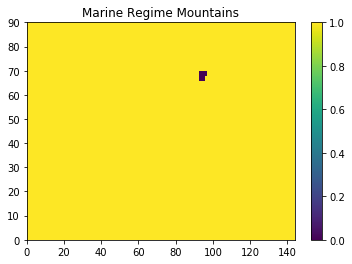

-----------------------------------------------------
Temperate Desert Division
mask requested Temperate Desert Division
unique values of mask [False  True]
shape of mask [False  True]


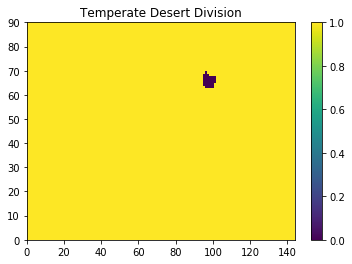

-----------------------------------------------------
Temperate Steppe Regime Mountains
mask requested Temperate Steppe Regime Mountains
unique values of mask [False  True]
shape of mask [False  True]


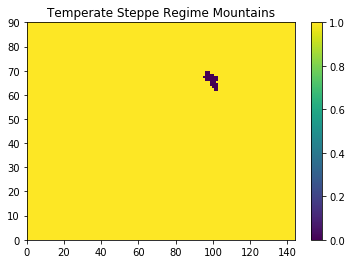

-----------------------------------------------------
Tropical/Subtropical Desert Division
mask requested Tropical Subtropical Desert Division
unique values of mask [False  True]
shape of mask [False  True]


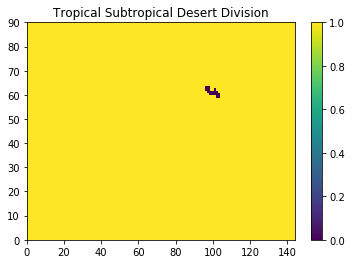

-----------------------------------------------------
Tropical/Subtropical Steppe Division
mask requested Tropical Subtropical Steppe Division
unique values of mask [False  True]
shape of mask [False  True]


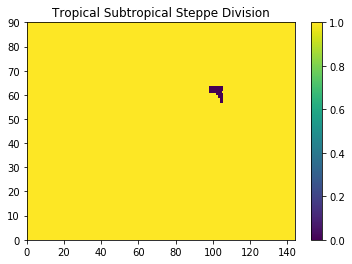

-----------------------------------------------------
Tropical/Subtropical Regime Mountains
mask requested Tropical Subtropical Regime Mountains
unique values of mask [False  True]
shape of mask [False  True]


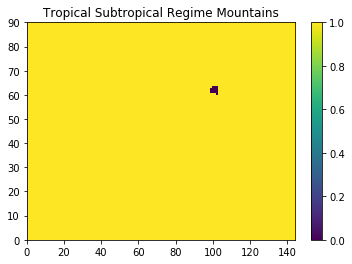

-----------------------------------------------------
Mediterranean Regime Mountains
mask requested Mediterranean Regime Mountains
unique values of mask [False  True]
shape of mask [False  True]


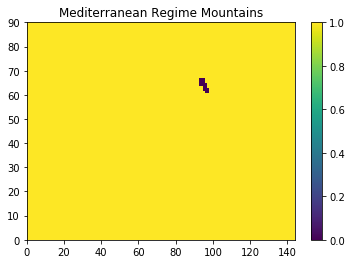

-----------------------------------------------------
Mediterranean Division
mask requested Mediterranean Division
unique values of mask [False  True]
shape of mask [False  True]


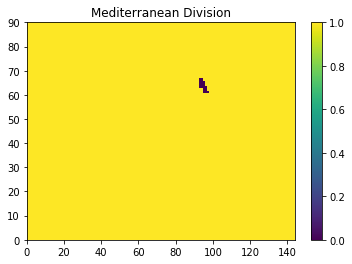

-----------------------------------------------------
Temperate Desert Regime Mountains
mask requested Temperate Desert Regime Mountains
unique values of mask [False  True]
shape of mask [False  True]


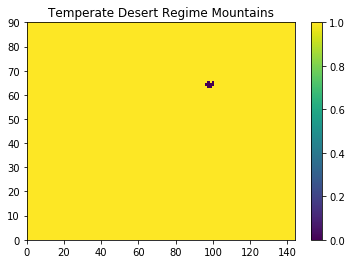

-----------------------------------------------------
western_US
mask requested western_US
unique values of mask [False  True]
shape of mask [False  True]


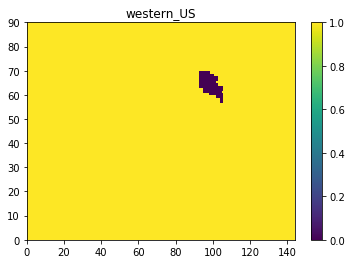

In [47]:
lasso_all_85_cmip5_dict = load_regression_cmip5_data(lasso_all_coefs, "lasso_all", "85", force_load=True)


### Use functions to load the CMIP5 data as time series

In [48]:
# Write the inception dictionary of division features
lasso_all_85_cmip5_dict = load_regression_cmip5_data(lasso_all_coefs, "lasso_all", "85", force_load)
lasso_atmos_85_cmip5_dict = load_regression_cmip5_data(lasso_atmos_coefs, "lasso_atmos", "85", force_load)
lasso_plant_85_cmip5_dict = load_regression_cmip5_data(lasso_plant_coefs, "lasso_plant", "85", force_load)

# Write the inception dictionary of division features
lasso_all_45_cmip5_dict = load_regression_cmip5_data(lasso_all_coefs, "lasso_all", "45", force_load)
lasso_atmos_45_cmip5_dict = load_regression_cmip5_data(lasso_atmos_coefs, "lasso_atmos", "45", force_load)
lasso_plant_45_cmip5_dict = load_regression_cmip5_data(lasso_plant_coefs, "lasso_plant", "45", force_load)

print("All requested CMIP5 data loaded/saved!")

lasso_all 85 dictionary being loaded from disk.
lasso_atmos 85 dictionary being loaded from disk.
lasso_plant 85 dictionary being loaded from disk.
lasso_all 45 dictionary being loaded from disk.
lasso_atmos 45 dictionary being loaded from disk.
lasso_plant 45 dictionary being loaded from disk.
All requested CMIP5 data loaded/saved!


### Unit sanity checks for variables where different units are stored for ERA-Interim and CMIP5. 
#### The following plots are PRE-bias correction
- This also serves as a sanity check on the unit conversion. 

In [49]:
def plot_unit_time_series(futures85, era_features, feature='pr_summer', units = "kg m$^{-2}$ s$^{-1}$") : 
    
    plt.figure(figsize=(10,6), dpi=150)

    ax=plt.subplot(111)

    for model in futures85.keys() :

        x = futures85[model].loc[:,feature].copy()
        if not np.isnan(x.iloc[0]) : 
            x.plot(label=model)
        del x
        
    era_features[feature].plot(label='ERA-Interim 1984-2016', linewidth=3, color="k")

    plt.ylabel(units)
    plt.title("Mean " + feature + " time series")
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="RCP8.5 | 1984-2100")

    plt.show()

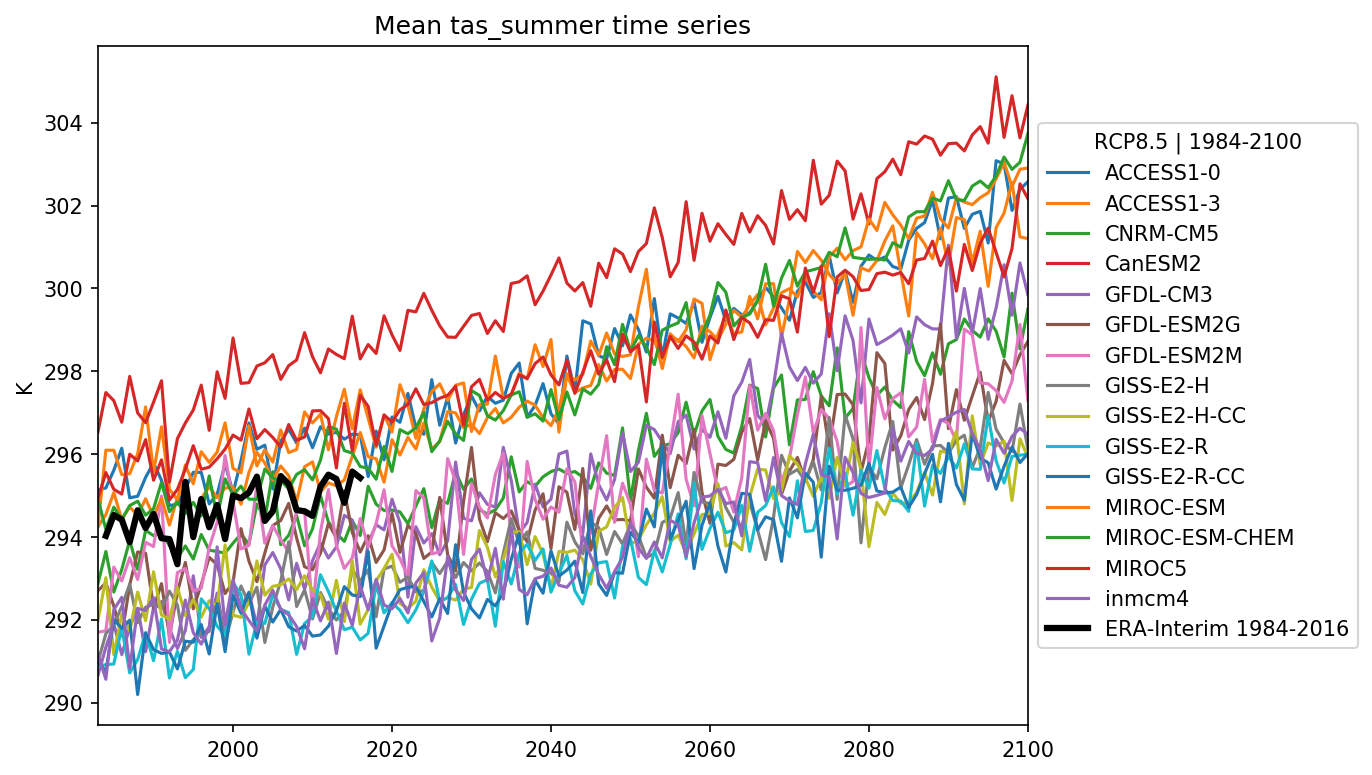

In [82]:
# perform check on a single division, lets say, 
futures85 = lasso_all_85_cmip5_dict["western_US"]
era_features = X_seasonal_dict["western_US"]
plot_unit_time_series(futures85, era_features, feature='tas_summer', units = "K")

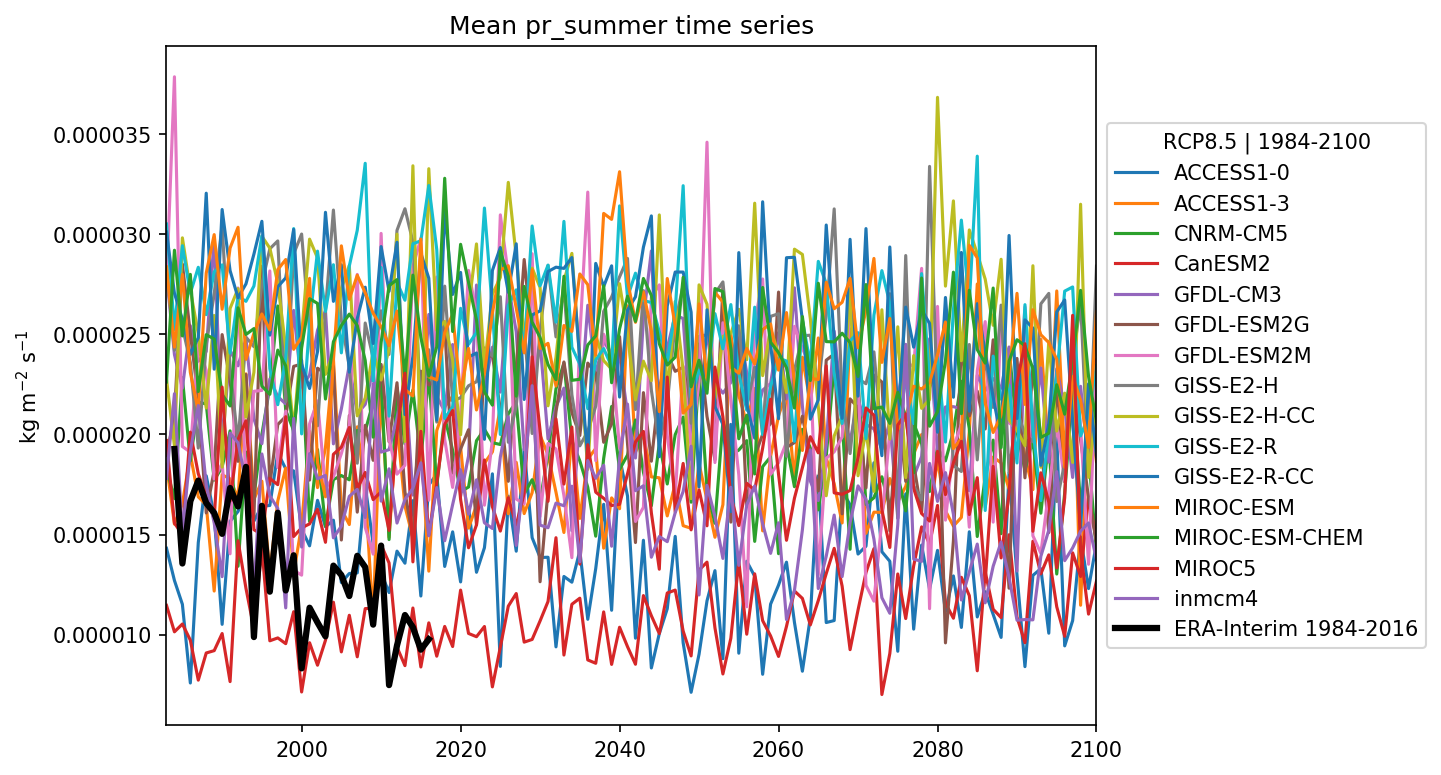

In [83]:
# perform check on a single division, lets say, 
futures85 = lasso_all_85_cmip5_dict["western_US"]
era_features = X_seasonal_dict["western_US"]
plot_unit_time_series(futures85, era_features, feature='pr_summer', units = "kg m$^{-2}$ s$^{-1}$")

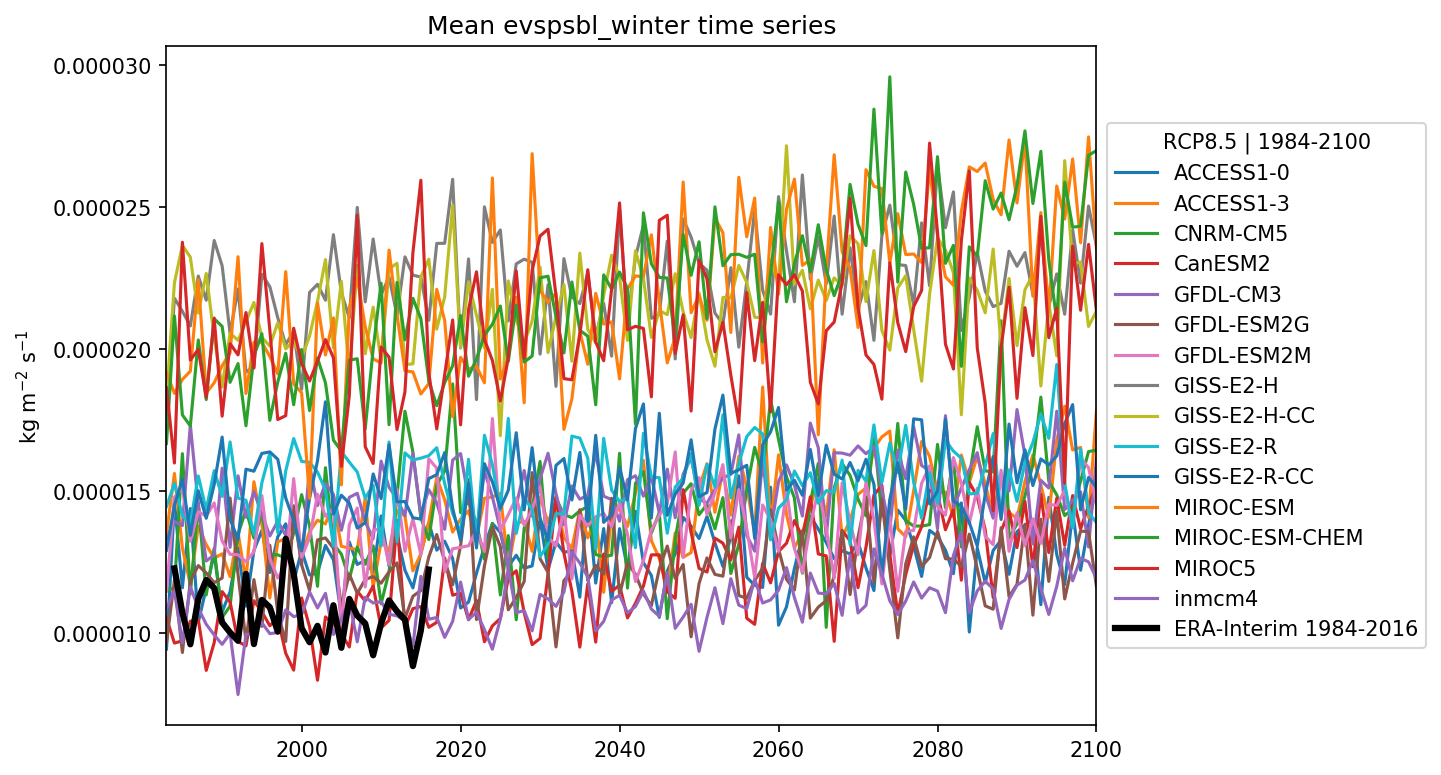

In [84]:
# perform check on a single division, lets say, 
futures85 = lasso_all_85_cmip5_dict['Marine Regime Mountains']
era_features = X_seasonal_dict['Marine Regime Mountains']
plot_unit_time_series(futures85, era_features, feature='evspsbl_winter', units = "kg m$^{-2}$ s$^{-1}$")

### Standardize CMIP5 output using ERA historical variance and mean. 
- This includes what most papers refer to as "bias correcting" CMIP5 data. 
- The purpose of this decision is to make is easy to compare data with different units. 
- To make it easy to understand how a variable changes from what has been observed to simulated by CMIP5 models. 

The historical period (1983-2016) CMIP5 data time series standard deviation is scaled to match the historical ERA-Interim standard deviation.  
This is done on the zero centered (mean removed) flattened (linear trend removed) time series for both. For variabes with trends, much of the standard deviation in the historical period is from the trend. We are forecasting year-to-year variability, so this trend must be removed for proper scaling. 

- The bias, offset, and standard deviation of each CMIP5 model is calibrated witht the following procedure:
    - Shown in bias_correct_cmip()

### Standardize the CMIP5 output and handle bias for all divisions. 
- Save as new dictionary
- TODO: handle trends within the overlap period. This could be important if sigma is driven by a trend rather than year to year variability.

In [50]:
def bias_correct_cmip(feature, div, model_name, X, y1=1984, y2=2016, inspect=False) : 
    """
    Scales the sigma of a CMIP5 model simulated feature to match
    the sigma observed by ERA-Iterim. The sigma is scaled using
    the overlapping years 1984-2016, all relevant sigmas are from 
    detrended series. 

    # TODO: Regression TYPE NEEDED IN SAVE INFORMATION. 

    Parameters
    ----------
        feature: str, the name of the feature being scaled. 
        div : the division data being scaled. used for getting correct detrended sigma. 
        X : pd.DataFrame, the CMIP5 dataframe with the feature to be scaled. Index of X
            used in regression within method. 

    Return
    ------
        x_fully_calibrated : np.array, where the detrended sigma (interannual) variance was scaled
                             so that np.std(x[y1:y2]) == era_ref_std and such that the historical
                             mean for y1-y2 matches era. Fully bias corrected. 
        sigma_ratio : ratio of y1:y2 detrended sigmas (era_ref_std / cmip_x_sub_flat_sigma).
                      good reference for figuring out how bad cmip simulates a given features. 
    """

    # tolerance for difference in historical overlap period 
    # sigma between model and observations. Ideally zero. There
    # are limitations. 
    tol = 1e-13

    # Get the mean and std values of the era_df_features to use to standardize 
    # the cmip model output by
    # TODO: Replace with reading the saved values! 
    era_ref_mean = pd.read_csv(os.path.join(save_dir_base, 'feature_means.csv'), index_col=0).loc[div, feature]
    era_ref_std  = pd.read_csv(os.path.join(save_dir_base, 'feature_std.csv'), index_col=0).loc[div, feature]
    
    if inspect :
        print("reference mean and std are : " + str(era_ref_mean) + " +- " + str(era_ref_std))

    # Get mask of overlapping years for scaling
    overlap_mask = ( X.index.values >= y1 ) & ( X.index.values <= y2 )

    years = X.index.values.copy()

    # Get the series to be scaled as numpy.array
    x = X.loc[:, feature].values.copy()
    #print(x)
    x_lm = stats.linregress(years, x)
    x_linear_fit = years*x_lm.slope + x_lm.intercept
    x_flat = signal.detrend(x)

    # Get the historical overlap years data with slope and offset 
    # NOTE: In false statement, this is how I first did this, 
    # NOTE: flattening the whole series then subsetting, but
    # NOTE: it makes more sense to detrend using local slope, 
    # NOTE: not 1984-2100 slope. 
    #x_sub_flat = x_flat[overlap_mask].copy()
    x_sub = x[overlap_mask].copy()
    x_sub_flat = signal.detrend(x_sub)

    x_sub_flat_sigma = np.std(x_sub_flat)
        
    # Ratio to scale the time series by. 
    sigma_ratio = era_ref_std / x_sub_flat_sigma

    # Make sure scaling makes ref period sigma match
    d = np.abs(era_ref_std - np.std(x_sub_flat * sigma_ratio))
    if d > tol :
        print("------> Comparisom of sigma error")
        print("Tolerance for difference is: " + str(tol))
        print("The observed diffefence is: " + str(d))
        raise ValueError("The scaling did not make sigmas match in reference period within tolerance. ")

    # use the ratio from the overlap period to scale the 
    # flattened longer time period 
    x_flat_scaled = x_flat * sigma_ratio
    
    # Add the slope and offset back into the time series 
    x_calibrated = x_flat_scaled + x_linear_fit

    # Now, replace the offset of x_calibrated with the historical mean
    # value for the overlap period
    x_calibrated_sub_mean = np.mean(x_calibrated[overlap_mask])

    # Seasonal sigma and overlap period offset both bias corrected 
    # i.e. replace cmip y1:y2 mean with era y1:y2 mean. 
    x_fully_calibrated = (x_calibrated - x_calibrated_sub_mean) + era_ref_mean
    
    if inspect : 

        fig_save_dir = os.path.join(save_dir_base, "bias_correction_curves")
        if not os.path.isdir(fig_save_dir) :
            os.mkdir(fig_save_dir)
            
        save_name = os.path.join(fig_save_dir, div.replace("/"," ")+"_"+feature+"_"+model_name+".png")
        
        plt.figure(dpi=150)
        plt.plot(years, x, label="x original")
        plt.plot(years, x_linear_fit, label = "x-linear fit")
        plt.plot(years, x_calibrated, "--", label="x variance calibrated")
        plt.axhline(y=era_ref_mean, linestyle="--", color="k", label="era reference mean")
        plt.plot(years, x_fully_calibrated, label="fully calibrated")
        plt.legend()
        plt.title(feature +" "+model_name +" scaled by %f factor" % sigma_ratio)
        plt.savefig(save_name)
        plt.close()

    return x_fully_calibrated, sigma_ratio

In [51]:
def standardize_cmip(div, cmip_dict, era_df_features, inspect=False) : 
    """
    Standardizes historical output using era reanlysis data fields. The 
    cmip5 model output bias is first corrected using bias_correct_cmip()
    then then standardized using historical (1984-2016) variance and width. 
    
    Parameters
    ----------
        cmip5_dict : A dictionary of CMIP5 output in pd.DataFrames. This 
                     function will loop over these models creating Z. 
        era_df_features : a pd.Dataframe of era features. Must exactly match
                          the features (columnames) in cmip5_dict dataframes. 
                          ERA feature means and standard deviations are 
                          calculated using this dataframe. 
                          
        Return
        ------
            A dictionary of pd.Dataframe where the keys are cmip5 model names
            and the values are the features standarized using historical (era)
            mean and variance. 
    """
    
    # Don't want any changes to be made outside of function 
    era_df_features = era_df_features.copy()
    
    # Read the mean and std values of the era_df_features to use to standardize 
    # the cmip model output by
    era_ref_mean = pd.read_csv(os.path.join(save_dir_base, 'feature_means.csv'), index_col=0).loc[div, :]
    era_ref_std  = pd.read_csv(os.path.join(save_dir_base, 'feature_std.csv'), index_col=0).loc[div, :]
        
    # A dictionary to store the standardized output 
    Z_futures_dict = {}
        
    # Get model names to loop over 
    model_names = cmip_dict.keys()
    n_models    = len(model_names) 
    
    # A DataFrame to record how much cmip model sigma are scaled 
    sigma_scale_df = pd.DataFrame(np.nan, columns=era_ref_mean.index.values, index=model_names)
    
    for model_name in model_names : 

        if inspect :
            print("------------------------------------------")
            print("Standardizing %s model output" % model_name)
            print("------------------------------------------")

        # Get the CMIP5 features dataframe from the futures dict
        cmip_df_features = cmip_dict[model_name].copy()
        cmip_years = np.array(cmip_df_features.index.values.copy())
        features = cmip_df_features.columns.values
        
        if inspect :
            print("The names of the cmip_df_features:")
            print(features)
            print("The names of the era_df_features:")
            print(era_df_features.columns.values)
            print(cmip_df_features.iloc[:2,:])

        # Use pd.DataFrame for nice storage. 
        Z_future_df = pd.DataFrame(0, columns=features, index=cmip_years)
        
        # Standardize (using historical mean and variance) 
        # the columns of these CMIP5 output 
        for feature in features : 
            
            if inspect :
                print("standardizing feature %s" % feature)
                print("%s first value: " %feature)
                print(cmip_df_features.loc[1984, feature])
            
            # If statement will figure out if the feature even exists
            # only features with non-zero coefs are loaded and need calibrating.
            # looking at the first value is enough, as all column values are np.nan
            # where there is no data. 
            if np.isnan(cmip_df_features.loc[1984, feature]) : 
                # If these data do not exist replace 0 with nan
                # so it is clear the data were traverserd
                Z_future_df.loc[:, feature] = np.nan
                if inspect : 
                    print("---------> No calibration for %s" %feature )
            else :
                # There are data!
                x_calibrated, sigma_ratio = bias_correct_cmip(feature, div, model_name, cmip_df_features, inspect=inspect)
                sigma_scale_df.loc[model_name, feature] = sigma_ratio
                #print(model_name + " sigma ratio: %f" % sigma_ratio)

                # Convert to z using historical values 
                xbar = era_ref_mean.loc[feature]
                xstd = era_ref_std.loc[feature]
                z = ( x_calibrated -  xbar) / xstd

                # Store the value
                Z_future_df.loc[:, feature] = z.copy()
                
        # Store in the dictionary
        Z_futures_dict[model_name] = Z_future_df   
            
    return Z_futures_dict, sigma_scale_df

In [52]:
def make_cmip5_Z_dict(regression_name, rcp, cmip_dict, X_seasonal_dict, inspect=False) :
    """
    
    Parameters
    ----------
        regression_name : str, The name of the regression 
        rcp : str, the desired RCP associated with the regression_name
        cmip_dict : A cmip5 dictionary created by get_CMIP5_features(), 
                    containing cmip5 data for non-zero coefs of associated
                    regression, for each ecoregion
        X_seasonal_dict : dictionary of pd.DataFrame, containing divisions
                          (index) by features (rows) of era-iterim data
                          used to train regressions and make ceofs.
                          
    return
    ------
        Z_cmip_dict : A dictionary where cmip5 data have been expressed in terms
                      of historical variance after being bias corrected. 
    """
    
    # Create descriptive file save name
    f1 = regression_name + "_" + "Z_cmip_" + rcp + "_dict.obj"
    print("Creating: " + os.path.join(save_dir_base, f1) ) 
    
    # Create an empty diction to store division Z dictionaries
    Z_cmip_dict = {}
    Z_sigma_scale_dict = {}
    
    for div in cmip_dict.keys() : 
        Z_cmip_dict[div], Z_sigma_scale_dict[div] = standardize_cmip(div, cmip_dict[div], X_seasonal_dict[div], inspect)

    # And save them for analysis
    with open(os.path.join(save_dir_base, f1), 'wb') as fp:
        pickle.dump(Z_cmip_dict, fp)
        
    # And save them for analysis
    f2 = regression_name + "_sigma_scale_cmip_" + rcp + "_dict.obj"
    with open(os.path.join(save_dir_base, f2), 'wb') as fp:
        pickle.dump(Z_sigma_scale_dict, fp)   
        
    return Z_cmip_dict, Z_sigma_scale_dict

#### Standardize the features for each division for :
- **Each regression type**
    - **RCP** 

#### Here is the absurd nesting of the functions that standardize CMIP5 output
- make_cmip5_Z_dict(regression_name, rcp, cmip_dict, X_seasonal_dict)
    - standardize_cmip(div, cmip5_dict[div], X_seasonal_dict[div])
        - bias_correct_cmip(cmip5_dict[div], X_seasonal_dict[div], feature)

In [53]:
Z_lasso_all_cmip_85_dict, _   = make_cmip5_Z_dict("lasso_all", "85", lasso_all_85_cmip5_dict, X_seasonal_dict)
Z_lasso_plant_cmip_85_dict, _ = make_cmip5_Z_dict("lasso_plant", "85", lasso_plant_85_cmip5_dict, X_seasonal_dict)
Z_lasso_atmos_cmip_85_dict, _ = make_cmip5_Z_dict("lasso_atmos", "85", lasso_atmos_85_cmip5_dict, X_seasonal_dict)

Z_lasso_all_cmip_45_dict, _   = make_cmip5_Z_dict("lasso_all", "45", lasso_all_45_cmip5_dict, X_seasonal_dict)
Z_lasso_plant_cmip_45_dict, _ = make_cmip5_Z_dict("lasso_plant", "45", lasso_plant_45_cmip5_dict, X_seasonal_dict)
Z_lasso_atmos_cmip_45_dict, _ = make_cmip5_Z_dict("lasso_atmos", "45", lasso_atmos_45_cmip5_dict, X_seasonal_dict)

Creating: ../Data/Fire_Analysis/CARTHAGE_MUST_BURN_50_transofromation_log10/lasso_all_Z_cmip_85_dict.obj
Creating: ../Data/Fire_Analysis/CARTHAGE_MUST_BURN_50_transofromation_log10/lasso_plant_Z_cmip_85_dict.obj
Creating: ../Data/Fire_Analysis/CARTHAGE_MUST_BURN_50_transofromation_log10/lasso_atmos_Z_cmip_85_dict.obj
Creating: ../Data/Fire_Analysis/CARTHAGE_MUST_BURN_50_transofromation_log10/lasso_all_Z_cmip_45_dict.obj
Creating: ../Data/Fire_Analysis/CARTHAGE_MUST_BURN_50_transofromation_log10/lasso_plant_Z_cmip_45_dict.obj
Creating: ../Data/Fire_Analysis/CARTHAGE_MUST_BURN_50_transofromation_log10/lasso_atmos_Z_cmip_45_dict.obj


Make z a pd.DataFrame Z, easier to plotting and handling

### Plot original data and Z time series 
- to make sure standardization and bias correction worked as planned 
- the units make sense
- the variance is an acceptable unit
- a way to be able to go back and look at the raw data for a variable and region and rcp of interest without having to run any more code

In [54]:
# Create a directory for time series figures, if it does not exist already
time_series_dir = os.path.join(save_dir_base, "time_series_figures")
if not os.path.isdir(time_series_dir) : 
    print("Creating a time series dir")
    os.mkdir(time_series_dir)
else : 
    print("Using an existing time series dir")

Creating a time series dir


In [57]:
era_ref_means = pd.read_csv(os.path.join(save_dir_base, 'feature_means.csv'), index_col=0)
era_ref_stds  = pd.read_csv(os.path.join(save_dir_base, 'feature_std.csv'), index_col=0)

In [98]:
# Get single division plotting data
for div in divisions : 
    #div = 'Temperate Steppe Regime Mountains'
    print("working on:", div)

    div_Z_85 = Z_lasso_all_cmip_85_dict[div]
    div_Z_45 = Z_lasso_all_cmip_45_dict[div]
    div_85 = lasso_all_85_cmip5_dict[div]
    div_45 = lasso_all_45_cmip5_dict[div]

    # Observations from ERA-Interim
    div_ERA = X_seasonal_dict[div]
    div_Z_ERA = Z_dict[div]

    # Plot each variable in division
    for variable in lasso_all_coefs.columns.values : 
        #variable = "tas_summer"

        fig = plt.figure(figsize=(10,10), dpi=300)

        # original units, original data, rcp 45 --------------
        ax1 = plt.subplot(221)
        for model_name in div_45.keys() : 
            div_45[model_name].plot(y=variable, ax=ax1, linewidth=0.5)
        div_ERA.plot(y=variable, c="k", linewidth=2, ax=ax1)
        ax1.legend_.remove()
        plt.title("RCP 4.5 original data")
        plt.ylabel("Native units")

        mu = era_ref_means.loc[div, variable]
        std = era_ref_stds.loc[div, variable]
        plt.axhline(mu, c="k", linestyle="--")
        plt.axhline(mu + std, c="k", linestyle="--")
        plt.axhline(mu - std, c="k", linestyle="--")


        # Z units, original data, rcp 45 --------------
        ax2 = plt.subplot(222)
        for model_name in div_Z_45.keys() : 
            div_Z_45[model_name].plot(y=variable, ax=ax2, linewidth=0.5)
        div_Z_ERA.plot(y=variable, c="k", linewidth=2, ax=ax2)
        ax2.legend_.remove()
        plt.title("RCP 4.5 transformed data")
        plt.ylabel("detrended sigma units")

        plt.axhline(0, c="k", linestyle="--")
        plt.axhline(1, c="k", linestyle="--")
        plt.axhline(-1, c="k", linestyle="--")

        # original units, original data, rcp 85 --------------
        ax3 = plt.subplot(223, sharey=ax1)
        for model_name in div_85.keys() : 
            div_85[model_name].plot(y=variable, ax=ax3, linewidth=0.5)
        div_ERA.plot(y=variable, c="k", linewidth=2, ax=ax3)
        ax3.legend_.remove()
        plt.title("RCP 8.5 original data")
        plt.ylabel("Native units")

        plt.axhline(mu, c="k", linestyle="--")
        plt.axhline(mu + std, c="k", linestyle="--")
        plt.axhline(mu - std, c="k", linestyle="--")

        # Z units,  rcp 85 --------------
        ax4 = plt.subplot(224)
        for model_name in div_Z_85.keys() : 
            div_Z_85[model_name].plot(y=variable, ax=ax4, linewidth=0.5)
        div_Z_ERA.plot(y=variable, c="k", linewidth=2, ax=ax4)
        ax4.legend_.remove()
        plt.title("RCP 8.5 transformed data")
        plt.ylabel("detrended sigma units")

        plt.axhline(0, c="k", linestyle="--")
        plt.axhline(1, c="k", linestyle="--")
        plt.axhline(-1, c="k", linestyle="--")
        
        # Show lasso_all coef value 
        coef = lasso_all_coefs.loc[div, variable]
        fig.suptitle(variable + " original and transformed | "+ str(coef), y=0.93)
        div_nice = div.replace("/","_")
        plt.savefig(os.path.join(time_series_dir, div_nice+"_"+variable+"_times_series.png"),  bbox_inches='tight')
        plt.close()

working on: Marine Regime Mountains
working on: Temperate Desert Division
working on: Temperate Steppe Regime Mountains
working on: Tropical/Subtropical Desert Division
working on: Tropical/Subtropical Steppe Division
working on: Tropical/Subtropical Regime Mountains
working on: Mediterranean Regime Mountains
working on: Mediterranean Division
working on: Temperate Desert Regime Mountains
working on: western_US


### Our definition of standardization :
- requires that mean values for Z_cmip5 is 0 between 1984-2016
- with a standard deviation of 1. 

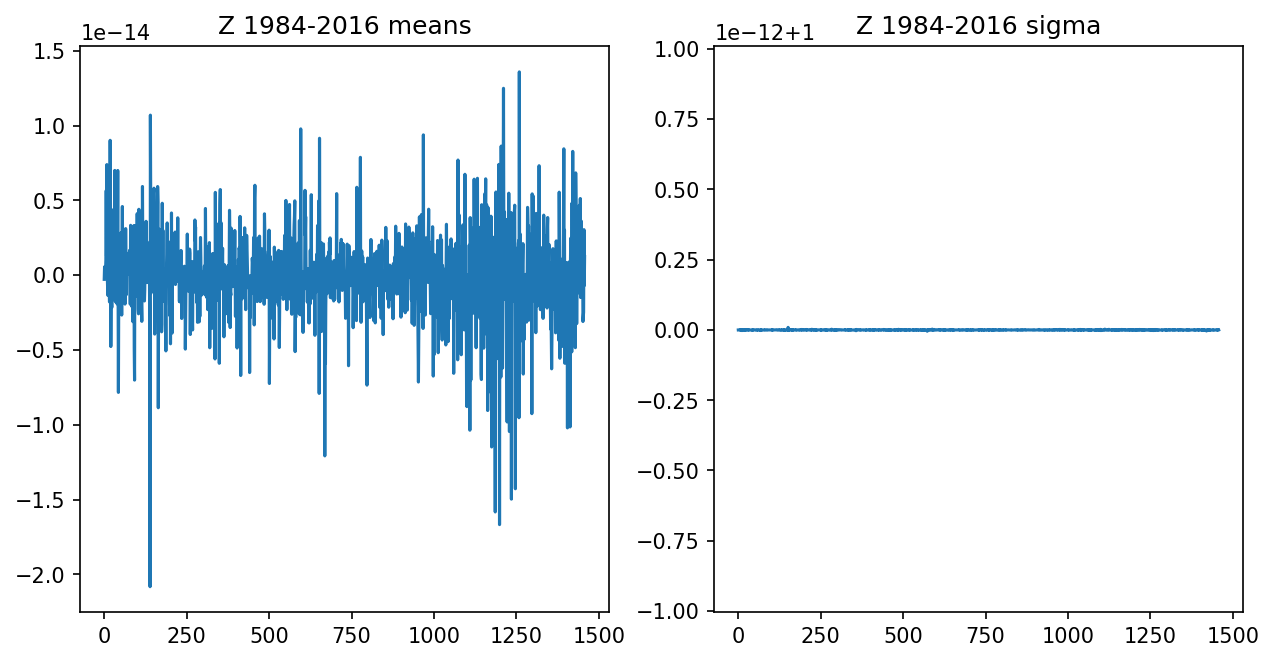

In [99]:
cmip_years = Z_lasso_all_cmip_85_dict['Marine Regime Mountains']['ACCESS1-0'].index.values
mean_vals = []
std_vals = []
for div in Z_lasso_plant_cmip_85_dict.keys() :
    for m in Z_lasso_plant_cmip_85_dict[div].keys() : 
        
        # Reverse order of operations on sigma calculation 
        z = Z_lasso_plant_cmip_85_dict[div][m]
        for feature in z.columns.values : 
            z_eg =  z.loc[:,feature].values
            #print(z_eg)
            if not np.isnan(z_eg[0]) :
                ym = (cmip_years >= 1984) & (cmip_years <= 2016)
                if False : # old way 
                    z1 = signal.detrend(z_eg)
                    std_vals.append( np.std(z1[ym]) )
                else : 
                    z1 = z_eg[ym]
                    std_vals.append( np.std( signal.detrend(z1) ) )
                    
                mean_vals.append( np.mean(z_eg[ym]) )
    
plt.figure(dpi=150, figsize=(10,5))
plt.subplot(121)
plt.plot(mean_vals)
plt.title("Z 1984-2016 means")
plt.subplot(122)
plt.plot(std_vals)
plt.title("Z 1984-2016 sigma")
plt.show()

In [100]:
print(np.min(std_vals))
print(np.max(std_vals))
print(np.min(mean_vals))
print(np.max(mean_vals))

0.9999999999999954
1.000000000000009
-2.081499955562377e-14
1.3581728334581081e-14


Plot everything used in this analysis as a sanity check. Once checked, remove from workspace. 

# Use the standardized CMIP output to make predictions using the trained linear regression
````Python 
div_lasso_list = {}    # A dictionary to store the trained regressions associated with divisions 
div_lasso_targets = {} # save what was fitted
div_relax_list = {}    # where the relaxo and lasso are saved. Gives critical information on coef kept, order, etc. 
div_ylog10 = {}        # Save the log10 values before detrending 
````

#### Here is a reminder of the operations done to the burn area target before fitting
This means for predictions to make sense, the mean seasonal burn area of the historical
data needs to be added to the predictions! 
````Python 
y_original = y_seanonal_df.loc[:, div].copy()

if transformation == "log10" :
    # We replace 0 values with 1 so that taking the base 10 logarithm is valid
    y_original.loc[y_original==0] = 1.
    y_log = np.log10(y_original.values)
    y_log_detrend = signal.detrend(y_log)
    y = y_log_detrend.copy()

    div_ylog10[div] = y_log

elif transformation == "none" : 
    # Do not alter the burn area, aside from taking the
    # autoregression (slope) away.
    y_detrend = signal.detrend(y_original)
    y = y_detrend.copy()

else :
    raise ValueError("tansformation not reconize. Choose valid transformation.")

````

Make sure that all of the needed variables were loaded from CMIP5. 

In [101]:
era_years = years
def make_BA_dictionary(regression_name, rcp, Z_dict, div_lasso_list, make_plots=False) : 
    """
    Uses the fit regularized regressions to estimate burn area. 
    
    Parameters 
    ----------
        regression_name : str, the name of the regression being used. lasso_all, 
                          lasso_atmos, lasso_plant.  
        rcp : str, the RCP scenario, 45 or 85. 
        Z_dict : dict, a dictionary with calibrated CMIP5 data, dataframes for 
                 each division. 
        div_lasso_list : dict, a dictionary of trained relaxo regressions. 
        make_plots : bool, whether to plot the burn area for a given regression 
                     cmip output combination. 
                     
    return
    ------
        A dictionary of burn areas. This dictionary is also written to disk
        by default

    """
    print("working on burn area projections using %s" % regression_name)
    print("For rcp %s" % rcp)
    
    # Create a directory to save burn area predictions 
    if make_plots :
        BA_save_dir = os.path.join(save_dir_base, "BA_projections")
        if not os.path.isdir(BA_save_dir) : 
            os.mkdir(BA_save_dir)
            
    # A dictionary of dataframes where each dataframes columns are
    # burn area projections for a single CMIP5 model 
    BA_dict = {}        
            
    # Only loop through divs that have data
    divs_with_fits = []
    for div in Z_dict.keys() : 
        if len(Z_dict[div].keys()) > 0 :
            divs_with_fits.append(div)
    #print(divs_with_fits)
        
    # Work on one division at a time
    for div in divs_with_fits : 
        
        #print("--------------------------------------------")
        #print(div)
        #print("--------------------------------------------")
    
        # Get the lasso regression model associated with this regression
        # and this division 
        # e.g. div_relax_list['Marine Regime Mountains']['lasso_atmos']
        # formorly # lasso_lm = div_lasso_list[div][regression_name]
        div_relaxo = div_lasso_list[div][regression_name]
        lasso_lm = div_relaxo.lasso_model
        
        # Get the dimensions of the burn area data to save 
        models_for_div = list(Z_dict[div].keys())
        z_years = Z_dict[div][models_for_div[0]].index.values.copy()
        
        # Create dataframe to store predictions [year X model]
        BA_df = pd.DataFrame(np.nan, columns=models_for_div, index = z_years)

        for model_name in models_for_div : 
            
            # Get the features for a given division & model 
            z_pred = Z_dict[div][model_name].copy()
                        
            # Get the names of the features fed to the second lasso 
            #(after variable selection step). 
            second_lasso_features = div_relaxo.X_second_lasso.columns.values
            #print("second_lasso_features:")
            #print(second_lasso_features)
            z_pred_subset = z_pred.loc[:, second_lasso_features].copy()
            
            # Make sure there are NO np.nan values in any of these columns. 
            # It could be a sign that there is a mismatch. Checking the 
            # first row of all columns of z_pred_subset should be enough. 
            if np.sum( np.isnan(z_pred_subset.values[0,:]) ) > 0 :
                
                # There should be no features with non-zero ceofs that
                # have nan values. Make that check too. 
                needed_features = lasso_lm.coef_ != 0
                if np.sum(np.isnan(z_pred_subset.values[0, needed_features])) > 0 :
                    print(div)
                    print("Working on model %s" % model_name)       
                    print("second_lasso_features:")
                    print(second_lasso_features)
                    print("z_pred_subset.columns.values")
                    print(z_pred_subset.columns.values)
                    print(z_pred_subset.values[0:2, :])
                    print("lasso_lm.coef_")
                    print(lasso_lm.coef_)
                    print("-------> Issue with the features for " + div + " model: " + m)
                    raise ValueError("There are nan values in feature CMIP5 columns for model " + m)
                    
                else :
                    # So there are nans, but not for features with non-zero coeficients. Good! 
                    # scikit-learn LassoCV will not allow nans in the dataframe, even for 
                    # columns that are meaningless, so turn those to zeros now. 0 * 0 is 
                    # no harm no foul
                    z_predictors = z_pred_subset.fillna(value=0)
            else :
                # There were no nans in the predictors dataframe once subset 
                # for features needed based on second lasso. 
                z_predictors = z_pred_subset.copy()
                
            z_column_names = z_predictors.columns.values.copy()
        
            # Get the mean value of the non-transformed target
            # because the mean was taken away for fitting. This will be added
            # to projected burn areas that are centered around zero by design. 
            if transformation == 'log10' : 
                y_bar = np.mean(div_ylog10[div])
            elif transformation == 'none' :
                y_bar = np.mean(div_BA_original[div])
            else :
                raise ValueError("Unrecognized data transformation " + transformation)

            # Lasso target, the y actually used for regression fitting. 
            # universal variable, defined waaaay above in script . 
            lasso_target = div_lasso_targets[div]+y_bar

            # make projection and get linear fit on that projection 
            # in case we want to talk about slopes, trends, etc. 
            y_predicted = lasso_lm.predict(z_predictors.values) + y_bar
            lm = stats.linregress(z_years, y_predicted)
            predicted_fit = lm.slope*z_years + lm.intercept

            # Save the burn area predicted by regression type driven my CMIP5 output
            BA_df.loc[:, model_name] = y_predicted

            if make_plots : 

                file_name = div.replace("/", " ") + "_" + model_name + "_"+ regression_name + "_rcp"+ rcp + "_burn_area.png"
                f = os.path.join(BA_save_dir, file_name)

                plt.figure(dpi=200, figsize=(6,3))
                plt.plot(z_years, y_predicted, label="predicted")
                plt.plot(z_years, predicted_fit, label="predicted regression")
                plt.plot(era_years, lasso_target, label="original target")
                plt.axhline(y=y_bar, color="k", linestyle="--", label="target mean")

                plt.legend()
                plt.title(div + " BA using "+ m)
                plt.ylabel("log$_{10}$(burn area [acres])")
                plt.savefig(f)
                plt.close()
        
        # Once the dataframe of models with burn area forecasts are made for a 
        # dividion save that information before the next division. 
        BA_dict[div] = BA_df.copy()
        del BA_df
        #print(" ")
            
    # Save the dictionary to disk
    f_dict = regression_name + "_BA_rcp" + rcp + ".obj"
    with open(os.path.join(save_dir_base, f_dict), 'wb') as fp:
        pickle.dump(BA_dict, fp)
    
    return BA_dict   

### Make burn area predictions and write them to disk. 

In [102]:
# This is now simply "temperature only"
BA_atmos_85 = make_BA_dictionary("lasso_atmos", "85", Z_lasso_atmos_cmip_85_dict, div_relax_list, make_plots=False)
BA_atmos_45 = make_BA_dictionary("lasso_atmos", "45", Z_lasso_atmos_cmip_45_dict, div_relax_list, make_plots=False)

working on burn area projections using lasso_atmos
For rcp 85
working on burn area projections using lasso_atmos
For rcp 45


In [103]:
# This is the lasso with all variable except temperature
BA_plant_85 = make_BA_dictionary("lasso_plant", "85", Z_lasso_plant_cmip_85_dict, div_relax_list, make_plots=False)
BA_plant_45 = make_BA_dictionary("lasso_plant", "45", Z_lasso_plant_cmip_45_dict, div_relax_list, make_plots=False)

working on burn area projections using lasso_plant
For rcp 85
working on burn area projections using lasso_plant
For rcp 45


In [104]:
# this is the lasso with all variables, including temperature, but it is not nessisaraly predicted. 
BA_all_85 = make_BA_dictionary("lasso_all", "85", Z_lasso_all_cmip_85_dict, div_relax_list, make_plots=False)
BA_all_45 = make_BA_dictionary("lasso_all", "45", Z_lasso_all_cmip_45_dict, div_relax_list, make_plots=False)

working on burn area projections using lasso_all
For rcp 85
working on burn area projections using lasso_all
For rcp 45


Sorry trees, snow, etc. At least the Baby Boomers will get to retire? 